In [1]:
# ============================================
# 🧠 Suicide Detection: Classical + BERT + Reduced Dim Models
# ============================================
# Author: chr (student project)
# Ready for publication / research comparison
# ============================================

!pip install scikit-learn transformers torch pandas numpy matplotlib seaborn -q

import pandas as pd, numpy as np, time, torch
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.base import clone
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")


In [2]:
# =======================================================
# 1️⃣ Load & Clean Data (Final Safe Version)
# =======================================================
import pandas as pd
import re

# --- Safe CSV loading ---
try:
    df = pd.read_csv(
        "Suicide_Detection.csv",
        engine="python",
        quoting=3,
        sep=",",
        on_bad_lines="skip",
        encoding="utf-8"
    )
except pd.errors.ParserError:
    print("⚠️ Parser error: retrying with alternate settings...")
    df = pd.read_csv(
        "Suicide_Detection.csv",
        engine="python",
        on_bad_lines="skip",
        quotechar='"',
        escapechar="\\",
        encoding="utf-8"
    )

# --- Drop rows missing text or class ---
df.dropna(subset=['text', 'class'], inplace=True)

# --- Normalize and clean class names ---
df['class'] = df['class'].str.strip().str.lower()  # normalize case + remove spaces

# ⚠️ DIFFERENCE from before:
# Previously, NaN appeared because map() failed on labels that were not EXACTLY
# "suicide" or "non-suicide" (e.g., extra spaces, case differences).
# We now normalize strings *before* mapping, and drop rows that remain unmapped.
df['class'] = df['class'].map({'suicide': 1, 'non-suicide': 0})
df = df.dropna(subset=['class'])  # removes unmapped or invalid labels ✅

# --- Clean text function ---
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)

# --- Check label balance ---
print(df['class'].value_counts(dropna=False))
print(f"✅ Cleaned dataset: {len(df)} rows")



class
1.0    2122
0.0    1580
Name: count, dtype: int64
✅ Cleaned dataset: 3702 rows


In [3]:

# ============================================================
# Split Data
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['class'], test_size=0.2, stratify=df['class'], random_state=42
)
print(f"Train={len(X_train)}  Test={len(X_test)}")

Train=2961  Test=741


In [4]:


# ============================================
# 🤖 Custom DistilBERT Embedding Wrapper
# ============================================
class BertVectorizer:
    def __init__(self, model_name='distilbert-base-uncased', max_len=128):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()
        self.max_len = max_len

    def encode_texts(self, texts):
        all_embeddings = []
        for text in texts:
            inputs = self.tokenizer(
                text, truncation=True, padding='max_length',
                max_length=self.max_len, return_tensors='pt'
            ).to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)
                emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.append(emb.squeeze())
        return np.array(all_embeddings)

    def fit(self, X, y=None): return self
    def transform(self, X): return self.encode_texts(X)

In [5]:


# ============================================
# ⚙️ Models
# ============================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear Regression": RidgeClassifier(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300),
    "kNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Perceptron": Perceptron(random_state=42),
}

In [6]:
# ============================================================
# ✅ STEP 3: Define Feature Spaces
# ============================================================
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

feature_spaces = {
    # Baseline TF-IDF
    "TFIDF": Pipeline([
        ("tfidf", TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words="english"
        ))
    ]),

    # Bag of Words
    "BoW": Pipeline([
        ("bow", CountVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words="english"
        ))
    ]),

    # TF-IDF + χ² Feature Selection (✅ fixed pipeline)
    "CHI2-1000": Pipeline([
        ("tfidf", TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words="english"
        )),
        ("chi2", SelectKBest(chi2, k=1000))
    ]),

    # TF-IDF + SVD (Latent Semantic)
    "SVD-300": Pipeline([
        ("tfidf", TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            stop_words="english"
        )),
        ("svd", TruncatedSVD(n_components=300, random_state=42))
    ])
}


In [7]:


# ============================================
# 📊 Evaluation Helper
# ============================================
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    try:
        proba = model.predict_proba(X_test)[:,1]
        roc = roc_auc_score(y_test, proba)
    except:
        roc = roc_auc_score(y_test, preds)
    return acc, f1, roc


In [8]:
results=[]
for feat_name, feat_pipe in feature_spaces.items():
    print(f"\n--- Feature: {feat_name} ---")
    X_train_trans = feat_pipe.fit_transform(X_train, y_train)
    X_test_trans  = feat_pipe.transform(X_test)
    for model_name, model in models.items():
        start = time.time()
        clf = clone(model)
        clf.fit(X_train_trans, y_train)
        acc, f1, roc = evaluate_model(clf, X_test_trans, y_test)
        elapsed = time.time() - start
        results.append([model_name, feat_name, acc, roc, f1, elapsed])
        print(f"{model_name:<20s} Acc={acc:.3f} F1={f1:.3f} ROC={roc:.3f} Time={elapsed:.2f}s")



--- Feature: TFIDF ---
Logistic Regression  Acc=0.750 F1=0.793 ROC=0.829 Time=0.05s
Linear Regression    Acc=0.752 F1=0.789 ROC=0.742 Time=0.03s
Neural Network       Acc=0.713 F1=0.751 ROC=0.772 Time=67.35s
kNN                  Acc=0.532 F1=0.487 ROC=0.588 Time=0.21s
Decision Tree        Acc=0.679 F1=0.724 ROC=0.669 Time=1.37s
Perceptron           Acc=0.684 F1=0.749 ROC=0.660 Time=0.02s

--- Feature: BoW ---
Logistic Regression  Acc=0.756 F1=0.789 ROC=0.826 Time=0.18s
Linear Regression    Acc=0.704 F1=0.738 ROC=0.701 Time=0.12s
Neural Network       Acc=0.707 F1=0.745 ROC=0.770 Time=65.92s
kNN                  Acc=0.637 F1=0.692 ROC=0.688 Time=0.14s
Decision Tree        Acc=0.675 F1=0.721 ROC=0.690 Time=0.48s
Perceptron           Acc=0.722 F1=0.752 ROC=0.720 Time=0.01s

--- Feature: CHI2-1000 ---
Logistic Regression  Acc=0.754 F1=0.795 ROC=0.826 Time=0.03s
Linear Regression    Acc=0.749 F1=0.785 ROC=0.741 Time=0.02s
Neural Network       Acc=0.733 F1=0.764 ROC=0.793 Time=14.72s
kNN     


===== Final Comparison Table =====
                  Model Feature Space  Accuracy   ROC-AUC        F1       Time
0   Logistic Regression           BoW  0.755735  0.825670  0.788798   0.176012
1   Logistic Regression     CHI2-1000  0.754386  0.825573  0.794582   0.026120
2     Linear Regression       SVD-300  0.751687  0.742949  0.787529   0.053406
3     Linear Regression         TFIDF  0.751687  0.742137  0.788506   0.026675
4   Logistic Regression         TFIDF  0.750337  0.828939  0.792833   0.047313
5     Linear Regression     CHI2-1000  0.748988  0.740596  0.784722   0.017697
6   Logistic Regression       SVD-300  0.746289  0.825782  0.787810   0.079197
7        Neural Network     CHI2-1000  0.732794  0.792640  0.763723  14.720421
8            Perceptron           BoW  0.721997  0.719907  0.751807   0.013236
9        Neural Network       SVD-300  0.720648  0.805261  0.767154  14.208701
10           Perceptron     CHI2-1000  0.719298  0.717148  0.749398   0.010343
11       Neural 

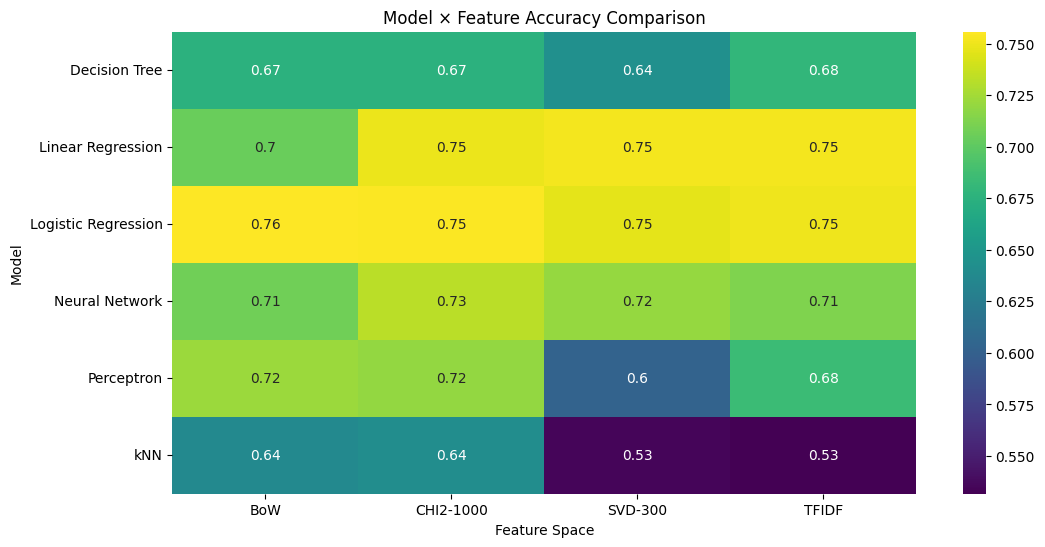

In [9]:
# ============================================
# 🧾 Results Table
# ============================================
res_df = pd.DataFrame(results, columns=["Model", "Feature Space", "Accuracy", "ROC-AUC", "F1", "Time"])
print("\n===== Final Comparison Table =====")
print(res_df.sort_values("Accuracy", ascending=False).reset_index(drop=True))

# ============================================
# 📈 Visualization
# ============================================


plt.figure(figsize=(12,6))
pivot_acc = res_df.pivot(index="Model", columns="Feature Space", values="Accuracy")
sns.heatmap(pivot_acc, annot=True, cmap="viridis")
plt.title("Model × Feature Accuracy Comparison")
plt.show()


In [10]:
# ============================================
# 🧪 Ensemble Blend (Late Fusion)
# ============================================
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Top 3 models by accuracy
top_models = res_df.groupby("Model")["Accuracy"].mean().sort_values(ascending=False).head(3).index

# Keep only models that support probability predictions
blend_estimators = [(m, models[m]) for m in top_models if hasattr(models[m], "predict_proba")]

tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# Use soft voting only if all support predict_proba()
blend = VotingClassifier(estimators=blend_estimators, voting='soft')
blend.fit(X_train_tfidf, y_train)

acc, f1, roc = evaluate_model(blend, X_test_tfidf, y_test)
print(f"\n🔹 Ensemble Blend ({', '.join([m for m,_ in blend_estimators])})")
print(f"Accuracy={acc:.3f}  F1={f1:.3f}  ROC={roc:.3f}")



🔹 Ensemble Blend (Logistic Regression, Neural Network)
Accuracy=0.721  F1=0.762  ROC=0.823


In [11]:
# ============================================================
# ⚡ STEP: Add Advanced Gradient Boosting Models
# ============================================================

!pip install -q xgboost lightgbm

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Add boosting models
models.update({
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        learning_rate=0.1,
        n_estimators=300,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
})

print("✅ Added XGBoost and LightGBM to models list.")


✅ Added XGBoost and LightGBM to models list.


In [12]:
# ============================================================
# ⚙️ Re-Evaluate All Models on Feature Spaces (Fixed for LightGBM)
# ============================================================

from sklearn.base import clone
import time

results_boosted = []

for feat_name, feat_pipe in feature_spaces.items():
    print(f"\n🧩 Feature Space: {feat_name}")
    X_train_trans = feat_pipe.fit_transform(X_train, y_train)
    X_test_trans  = feat_pipe.transform(X_test)

    # 🔧 Ensure numeric float32 type for LightGBM/XGBoost compatibility
    if hasattr(X_train_trans, "astype"):
        X_train_trans = X_train_trans.astype(np.float32)
        X_test_trans  = X_test_trans.astype(np.float32)

    for model_name, model in models.items():
        start = time.time()
        clf = clone(model)
        clf.fit(X_train_trans, y_train)

        preds = clf.predict(X_test_trans)
        if hasattr(clf, "predict_proba"):
            probs = clf.predict_proba(X_test_trans)[:, 1]
        else:
            probs = preds

        acc = accuracy_score(y_test, preds)
        f1  = f1_score(y_test, preds)
        try:
            roc = roc_auc_score(y_test, probs)
        except:
            roc = np.nan

        elapsed = time.time() - start
        results_boosted.append([model_name, feat_name, acc, roc, f1, elapsed])
        print(f"{model_name:<20s} | Acc={acc:.3f} | F1={f1:.3f} | ROC={roc:.3f} | Time={elapsed:.2f}s")

# Convert results to DataFrame
boosted_df = pd.DataFrame(results_boosted, columns=["Model", "Feature", "Accuracy", "ROC-AUC", "F1", "Time"])
boosted_df.sort_values("Accuracy", ascending=False, inplace=True)

print("\n===== 🔥 Final Comparison Table (Including Boosting Models) =====")
print(boosted_df.head(10))



🧩 Feature Space: TFIDF
Logistic Regression  | Acc=0.750 | F1=0.793 | ROC=0.829 | Time=0.17s
Linear Regression    | Acc=0.752 | F1=0.789 | ROC=0.742 | Time=0.12s
Neural Network       | Acc=0.711 | F1=0.753 | ROC=0.775 | Time=29.52s
kNN                  | Acc=0.556 | F1=0.475 | ROC=0.633 | Time=0.13s
Decision Tree        | Acc=0.686 | F1=0.733 | ROC=0.677 | Time=1.10s
Perceptron           | Acc=0.684 | F1=0.749 | ROC=0.660 | Time=0.02s
XGBoost              | Acc=0.719 | F1=0.758 | ROC=0.797 | Time=5.78s
[LightGBM] [Info] Number of positive: 1697, number of negative: 1264
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5446
[LightGBM] [Info] Number of data points in the train set: 2961, number of used features: 254
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.573117 -> initscore=

In [14]:
!pip install pandas spacy geopy folium matplotlib
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
# subset_pipeline.py
import json
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import spacy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# CONFIG
DATA_CSV = "Suicide_Detection.csv"
OUT_SUBSET_CSV = "subset_for_geocode.csv"
CACHE_PATH = Path("geo_cache.json")
NLP_BATCH = 256
MIN_DELAY_SECONDS = 1.0  # Nominatim policy; adjust if using another geocoder
SAMPLE_N = 5000         # change to how large a subset you want

# Load
df = pd.read_csv(DATA_CSV, engine="python", on_bad_lines="skip", encoding="utf-8")
df = df.dropna(subset=['text', 'class']).reset_index(drop=True)
# normalize class mapping (safe guard)
df['class'] = df['class'].astype(str).str.strip().str.lower().map({'suicide':1,'non-suicide':0})
df = df.dropna(subset=['class'])

# 1) Create subset (stratified recommended)
from sklearn.model_selection import train_test_split

subset, _ = train_test_split(
    df,
    train_size=SAMPLE_N,
    stratify=df['class'],
    random_state=42
)

subset = subset.reset_index(drop=True)
subset.to_csv(OUT_SUBSET_CSV, index=False)
print("Created subset:", len(subset), "->", OUT_SUBSET_CSV)


# 2) NER extraction using spaCy pipe + tqdm
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger"])  # keep NER only
def is_valid_location(place):
    blacklist = set(["ill","thighs","cousin","chinese ai","dad","school","class","me","him","her","feeling","pain","hospital"])
    if not place:
        return False
    s = place.strip().lower()
    if s in blacklist or len(s) < 2:
        return False
    return True

def extract_locations(texts):
    places_out = []
    it = nlp.pipe(texts, batch_size=NLP_BATCH)
    for doc in tqdm(it, total=len(texts), desc="spaCy NER"):
        places = []
        for ent in doc.ents:
            if ent.label_ in ("GPE", "LOC"):
                cand = ent.text.strip()
                if is_valid_location(cand) and cand not in places:
                    places.append(cand)
        places_out.append(", ".join(places) if places else None)
    return places_out

subset['Location'] = extract_locations(subset['text'].astype(str).tolist())
subset.to_csv("subset_with_location.csv", index=False)
print("Saved subset_with_location.csv")

# 3) Geocode unique place strings only (with caching)
geolocator = Nominatim(user_agent="subset_geocoder_v1")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=MIN_DELAY_SECONDS)

def load_cache(path=CACHE_PATH):
    if path.exists():
        try:
            return json.loads(path.read_text(encoding="utf-8"))
        except Exception:
            return {}
    return {}

def save_cache(cache, path=CACHE_PATH):
    path.write_text(json.dumps(cache, ensure_ascii=False, indent=2), encoding="utf-8")

def geocode_place(place, cache):
    if not place:
        return None, None
    if place in cache:
        v = cache[place]
        return (v[0], v[1]) if v else (None, None)
    try:
        loc = geocode(place, timeout=10)
        if loc:
            cache[place] = (loc.latitude, loc.longitude)
            return loc.latitude, loc.longitude
        # fallback on first token
        first_tok = place.split(",")[0].strip()
        if first_tok and first_tok not in cache:
            loc = geocode(first_tok, timeout=10)
            if loc:
                cache[place] = (loc.latitude, loc.longitude)
                return loc.latitude, loc.longitude
    except Exception as e:
        print("Geocode error:", e)
    cache[place] = None
    return None, None

cache = load_cache()
unique_places = [p for p in subset['Location'].dropna().unique()]
print("Unique places to geocode:", len(unique_places))

for i, place in enumerate(tqdm(unique_places, desc="Geocoding")):
    if place in cache:
        continue
    lat, lon = geocode_place(place, cache)
    # optional: print every N
    if i % 50 == 0:
        print(f"[{i}/{len(unique_places)}] {place} -> {lat}, {lon}")
    # optionally save cache periodically
    if i % 100 == 0:
        save_cache(cache)

save_cache(cache)

# 4) map coordinates back and save
def lookup_coords(place, cache):
    if not place:
        return (None, None)
    val = cache.get(place)
    if not val:
        return (None, None)
    return val

coords = subset['Location'].apply(lambda p: lookup_coords(p, cache))
subset['Latitude'] = coords.apply(lambda v: v[0])
subset['Longitude'] = coords.apply(lambda v: v[1])

subset.to_csv("subset_geocoded.csv", index=False)
print("Saved subset_geocoded.csv")


Created subset: 5000 -> subset_for_geocode.csv


spaCy NER: 100%|██████████| 5000/5000 [01:28<00:00, 56.60it/s]


Saved subset_with_location.csv
Unique places to geocode: 313


Geocoding:   0%|          | 1/313 [00:00<02:22,  2.19it/s]

[0/313] Anything -> 40.6612554, -73.9534005


Geocoding:  16%|█▋        | 51/313 [01:02<06:12,  1.42s/it]

[50/313] hypersomnia -> None, None


Geocoding:  32%|███▏      | 101/313 [02:02<04:02,  1.14s/it]

[100/313] Arkansas, Texas -> 30.1089271, -94.6412979


Geocoding:  48%|████▊     | 151/313 [03:08<04:15,  1.58s/it]

[150/313] Florida -> 27.7567667, -81.4639835


Geocoding:  64%|██████▍   | 201/313 [04:08<02:07,  1.13s/it]

[200/313] bad?I -> 52.1196408, -97.8006981


Geocoding:  80%|████████  | 251/313 [05:13<01:16,  1.23s/it]

[250/313] UK, Europe, Venice, Dystonia -> None, None


Geocoding:  96%|█████████▌| 301/313 [06:19<00:13,  1.11s/it]

[300/313] the east coast -> 41.506534, -81.6939953


Geocoding: 100%|██████████| 313/313 [06:35<00:00,  1.26s/it]

Saved subset_geocoded.csv


In [55]:
import pandas as pd
import folium
from folium.plugins import HeatMap
import plotly.express as px

def generate_location_visualizations(csv_path,
                                     lat_col="Latitude",
                                     lon_col="Longitude",
                                     location_col="Location",
                                     heatmap_file="crisis_heatmap.html"):
    """
    Generate a heatmap + top location statistics from a geocoded CSV file.

    Parameters:
        csv_path (str): Path to the CSV file
        lat_col (str): Name of the latitude column
        lon_col (str): Name of the longitude column
        location_col (str): Name of the text column containing city/country names
        heatmap_file (str): Output file name for the heatmap HTML

    Returns:
        df_valid (DataFrame): Filtered dataframe with valid coordinates
    """

    print("Loading:", csv_path)
    df = pd.read_csv(csv_path)

    # Filter out missing coordinates
    df_valid = df.dropna(subset=[lat_col, lon_col])
    print(f"Valid rows with coordinates: {len(df_valid)}")

    if df_valid.empty:
        print("No valid latitude/longitude rows found. Nothing to visualize.")
        return df_valid

    # =======================
    # Heatmap Visualization
    # =======================
    print("Creating heatmap...")

    map_center = [
        df_valid[lat_col].mean(),
        df_valid[lon_col].mean()
    ]

    heatmap_map = folium.Map(location=map_center, zoom_start=2)

    heat_data = df_valid[[lat_col, lon_col]].values.tolist()
    HeatMap(heat_data).add_to(heatmap_map)

    heatmap_map.save(heatmap_file)
    print(f"Heatmap saved as {heatmap_file}")

    # =======================
    # Top 5 locations
    # =======================
    print("\n Top 5 Locations:")
    top_locations = df_valid[location_col].value_counts().head(5)
    print(top_locations)

    top_df = top_locations.reset_index()
    top_df.columns = ["Location", "Count"]

    fig = px.bar(top_df, x="Location", y="Count",
                 title="Top 5 Crisis Discussion Locations")
    fig.show()

    # =======================
    # All locations
    # =======================
    print("\n All Locations Count:")
    all_locations = df_valid[location_col].value_counts()
    print(all_locations)

    all_df = all_locations.reset_index()
    all_df.columns = ["Location", "Count"]

    fig2 = px.bar(all_df, x="Location", y="Count",
                  title="All Crisis Discussion Locations")
    fig2.show()

    return df_valid


Approach 1 using similarity of sentence locations didn't work well.

In [59]:
# fast_location_filter.py
import pandas as pd
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer, util

# Load dataset
df = pd.read_csv("subset_geocoded.csv")

# Remove missing
df = df.dropna(subset=["Location", "Latitude", "Longitude", "text"])

# Load fast embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Precompute embeddings for all texts
print("Encoding post texts...")
text_embeddings = model.encode(df["text"].tolist(), batch_size=64, convert_to_tensor=True)

# Encode candidate locations
print("Encoding location strings...")
loc_embeddings = model.encode(df["Location"].tolist(), batch_size=64, convert_to_tensor=True)

print("Computing similarities...")
similarities = util.cos_sim(text_embeddings, loc_embeddings).diagonal().cpu().numpy()

df["sim_score"] = similarities
THRESH = 0.50
df_filtered = df[df["sim_score"] >= THRESH].copy()
df_filtered.to_csv("subset_geocoded_fast_filtered.csv", index=False)

print("Filtered rows:", len(df_filtered), "out of", len(df))


Encoding post texts...
Encoding location strings...
Computing similarities...
Filtered rows: 22 out of 380


In [60]:
df_cleaned = generate_location_visualizations(
    "/content/subset_geocoded_fast_filtered.csv",
    lat_col="Latitude",
    lon_col="Longitude",
    location_col="Location",
    heatmap_file="crisis_heatmap_fast.html"
)


Loading: /content/subset_geocoded_fast_filtered.csv
Valid rows with coordinates: 22
Creating heatmap...
Heatmap saved as crisis_heatmap_fast.html

 Top 5 Locations:
Location
Binod                      1
Las Vegas, Wuhan, Vegas    1
KY                         1
Santa                      1
Spotify                    1
Name: count, dtype: int64



 All Locations Count:
Location
Binod                      1
Las Vegas, Wuhan, Vegas    1
KY                         1
Santa                      1
Spotify                    1
Seattle                    1
phobia                     1
anesthesia                 1
Banan                      1
Akaza                      1
BDSM                       1
Articuno                   1
Lucas                      1
Belarus, Minsk             1
Ireland                    1
Hoodies, n’t, Anyway       1
America, KKK               1
Netflix                    1
west america               1
Smash                      1
UC                         1
Osaka                      1
Name: count, dtype: int64


Approach 2 specifies 500cities from geonames.org and is much more accurate than the earlier approach of checking smilarity.

In [39]:
pip install https://github.com/elyase/geotext/archive/master.zip

     - 2.3 MB 6.8 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for geotext: filename=geotext-0.3.0-py2.py3-none-any.whl size=2272468 sha256=885a0c955c91735cb20bcb2d5660acba26e10bb650ad72973329dc9d5b6262d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-2u1bvrwt/wheels/dd/cb/dd/aa64c3d553e0f6206b3f8d422575931c6ac4d02d975dc3a098
Successfully built geotext


In [46]:
!wget https://download.geonames.org/export/dump/cities500.zip


--2025-11-15 11:22:43--  https://download.geonames.org/export/dump/cities500.zip
Resolving download.geonames.org (download.geonames.org)... 5.9.152.54
Connecting to download.geonames.org (download.geonames.org)|5.9.152.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12559260 (12M) [application/zip]
Saving to: ‘cities500.zip’

cities500.zip       100%[===================>]  11.98M  11.0MB/s    in 1.1s    

2025-11-15 11:22:45 (11.0 MB/s) - ‘cities500.zip’ saved [12559260/12559260]



In [48]:
!unzip -o cities500.zip -d /content/

Archive:  cities500.zip
  inflating: /content/cities500.txt  


In [62]:
import pandas as pd

geo = pd.read_csv("cities500.txt", sep="\t", header=None, dtype=str)

geo = geo[[1, 4, 5]]   # name, latitude, longitude
geo.columns = ["name", "lat", "lon"]

# lowercase for easy matching
geo["name"] = geo["name"].str.lower()


In [65]:
from geotext import GeoText
import pandas as pd

df = pd.read_csv("subset_geocoded.csv")

def extract_real_locations(text):
    places = GeoText(text)
    locs = list(set(places.cities + places.countries))
    return ", ".join(locs) if locs else None

df["RealLocation"] = df["text"].apply(extract_real_locations)
df = df.dropna(subset=["RealLocation"])

lookup = dict(zip(geo["name"], zip(geo["lat"], geo["lon"])))

def geocode_local(place):
    if not place:
        return (None, None)
    place = place.strip().lower()
    return lookup.get(place, (None, None))

df["Latitude"], df["Longitude"] = zip(*df["RealLocation"].apply(geocode_local))

df = df.dropna(subset=["Latitude", "Longitude"])
df.to_csv("subset_geocoded_local.csv", index=False)


In [66]:
df_cleaned = generate_location_visualizations(
    "/content/subset_geocoded_local.csv",
    lat_col="Latitude",
    lon_col="Longitude",
    location_col="RealLocation",
    heatmap_file="crisis_heatmap_cleaned.html"
)


Loading: /content/subset_geocoded_local.csv
Valid rows with coordinates: 242
Creating heatmap...
Heatmap saved as crisis_heatmap_cleaned.html

 Top 5 Locations:
RealLocation
Most          42
Of            31
Man           12
Best          10
University    10
Name: count, dtype: int64



 All Locations Count:
RealLocation
Most             42
Of               31
Man              12
Best             10
University       10
                 ..
Santa Barbara     1
Alexandria        1
Doral             1
Parker            1
Independence      1
Name: count, Length: 87, dtype: int64


Reddit posts classification into 3 risk levels

In [67]:
with open("requirements.txt","w") as file:
  file.write("praw\nnltk\nemoji\ntextblob\nvaderSentiment\nscikit-learn\nsentence-transformers\npandas\nmatplotlib\nspacy\nseaborn\nfolium\ngeopy\n")

In [68]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.6 MB/s eta 0:00:00


In [71]:
#A Python script that retrieves and stores filtered social media posts.
import praw
import csv
from datetime import datetime
from datetime import timezone
# Define keywords
keywords = [
    "depressed", "addiction help", "overwhelmed", "suicidal", "drug addict",
    "psycho", "anxious", "panic attack", "no one", "tired",
    "die", "kill", "failure", "mental breakdown", "hurting"
]
keywords = [k.lower() for k in keywords]
'''
# Initialize Reddit API -UPDATE: CREDENTIALS HAVE GOTTEN OUTDATED RECENTLY PERHAPS BECAUSE IT GIVES 401 ERROR NOW.
reddit = praw.Reddit(
    client_id="tOIV4gYbS1r57DzNVoqmeA",
    client_secret="qm6rE30HovcZqubY7Zqj8MT_30fNZA",
    user_agent="script:mental_health_filter:v1.0 (by u/BerryFar3503)"
)

# Target subreddits
subreddit = reddit.subreddit("depression+SuicideWatch+MentalHealthSupport+SubstanceAbuseHelp")

# Write to CSV
with open("filtered_reddit_posts.csv", "w", newline='', encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow([
        "Post_ID","Timestamp", "Content", "score(Upvotes-Downvotes)", "num_comments","upvote_ratio"
    ])


    for submission in subreddit.new(limit=100):
        combined_text = (submission.title + " " + submission.selftext).lower()
        if any(keyword in combined_text for keyword in keywords):
            created_time = datetime.fromtimestamp(submission.created_utc, tz=timezone.utc).strftime("%Y-%m-%d %H:%M:%S")
            writer.writerow([
                submission.id,
                created_time,
                submission.selftext.replace('\n', ' ').replace('\r', ' '),
                submission.score,
                submission.num_comments,
                submission.upvote_ratio
            ])
'''
#A cleaned dataset ready for NLP analysis.
import csv
import re
import emoji
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):

    # Remove emojis
    text = emoji.replace_emoji(text, replace='')

    # Remove all special characters except selected punctuation
    text = re.sub(r"[^a-zA-Z0-9\s,\.!?\"';:]", '', text)

    # Remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]

    return " ".join(filtered_words)

# Input and output files
input_file = "filtered_reddit_posts.csv"
output_file = "reddit_cleaned_posts.csv"

with open(input_file, "r", encoding="utf-8") as infile, \
     open(output_file, "w", newline='', encoding="utf-8") as outfile:

    reader = csv.DictReader(infile)
    fieldnames = reader.fieldnames
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()

    for row in reader:
        row["Content"] = clean_text(row["Content"])
        writer.writerow(row)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


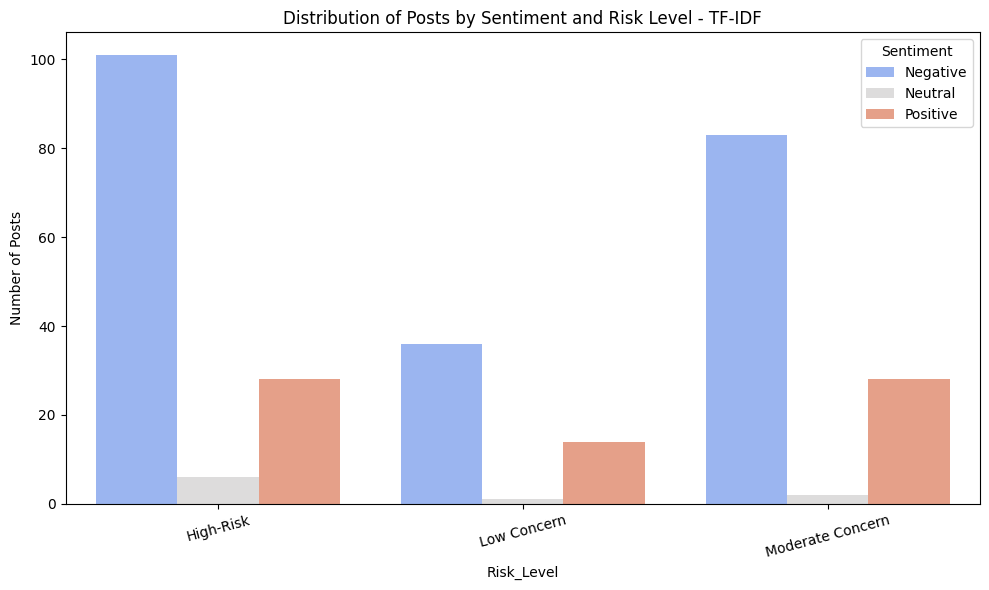

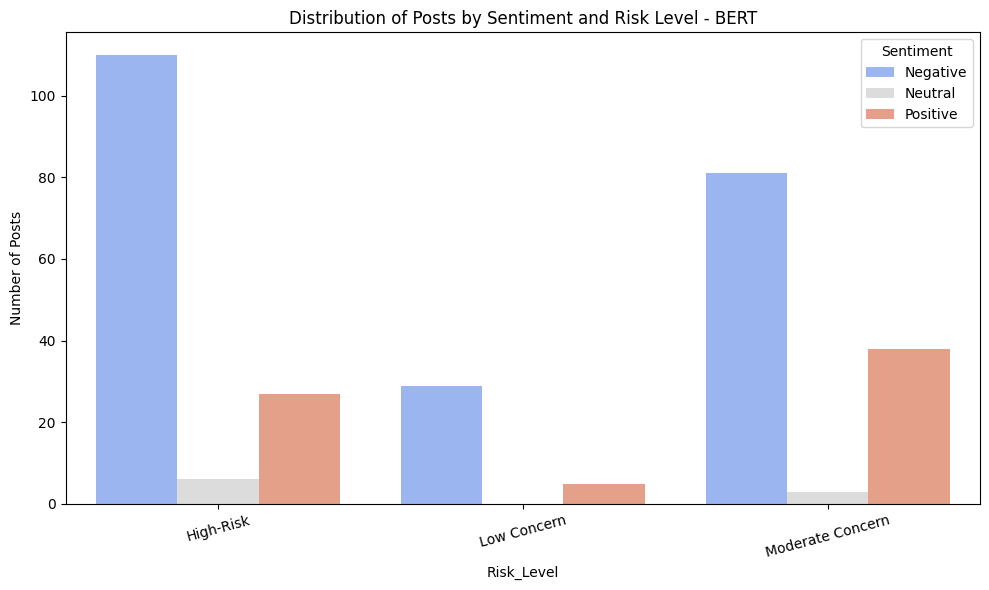

In [73]:
#A script that classifies posts based on sentiment and risk level.
#Apply VADER (for Twitter) or TextBlob for sentiment classification (Positive, Neutral, Negative).
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

def get_sentiment_textblob(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.05:
        return "Positive"
    elif polarity < -0.05:
        return "Negative"
    else:
        return "Neutral"
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()
def get_sentiment_vader(text):
    score = analyzer.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

input_file = "reddit_cleaned_posts.csv"
output_file = "reddit_sentiment_posts.csv"

with open(input_file, "r", encoding="utf-8") as infile, \
     open(output_file, "w", newline='', encoding="utf-8") as outfile:

    reader = csv.DictReader(infile)
    fieldnames = reader.fieldnames + ["Sentiment"]
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()

    for row in reader:
        content = row["Content"]
        row["Sentiment"] = get_sentiment_vader(content) # get_sentiment_vader can be replaced with get_sentiment_textblob as required.
        writer.writerow(row)

#Use TF-IDF or Word Embeddings (BERT, Word2Vec) to detect high-risk crisis terms.
high_risk_terms = [
    "i don’t want to be here anymore", "i want to die", "ending it", "kill myself", "suicidal", "give up", "no reason to live"
]

moderate_risk_terms = [
    "i feel lost", "need help", "struggling", "can’t cope", "overwhelmed", "depressed", "feel alone"
]

low_risk_terms = [
    "mental health", "anxiety", "therapy", "stress", "feeling better", "journaling", "mindfulness"
]
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load the data
df = pd.read_csv("reddit_cleaned_posts.csv")

# Corpus = post content + crisis phrases
all_phrases = high_risk_terms + moderate_risk_terms + low_risk_terms
corpus = df["Content"].tolist() + all_phrases

# TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

# Calculate similarity of each post to each category
post_vectors = X[:-len(all_phrases)]
high_risk_vecs = X[-len(all_phrases):-len(moderate_risk_terms)-len(low_risk_terms)]
moderate_vecs = X[-len(moderate_risk_terms)-len(low_risk_terms):-len(low_risk_terms)]
low_vecs = X[-len(low_risk_terms):]

def compute_max_sim(post_vec, category_vecs):
    sims = cosine_similarity(post_vec, category_vecs)
    return sims.max()

risk_levels = []
for i in range(len(df)):
    post_vec = post_vectors[i]

    high_sim = compute_max_sim(post_vec, high_risk_vecs)
    mod_sim = compute_max_sim(post_vec, moderate_vecs)
    low_sim = compute_max_sim(post_vec, low_vecs)
    maxval=max(high_sim,mod_sim,low_sim)
    if high_sim ==maxval:
        risk_levels.append("High-Risk")
    elif mod_sim ==maxval:
        risk_levels.append("Moderate Concern")
    else:
        risk_levels.append("Low Concern")

df["Risk_Level"] = risk_levels
df.to_csv("reddit_with_risk_levels_TFIDF.csv", index=False)

from sentence_transformers import SentenceTransformer, util
import torch
model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(df["Content"].tolist(), convert_to_tensor=True)
high_embeds = model.encode(high_risk_terms, convert_to_tensor=True)
mod_embeds = model.encode(moderate_risk_terms, convert_to_tensor=True)
low_embeds = model.encode(low_risk_terms, convert_to_tensor=True)

risk_levels = []
for post_emb in embeddings:
    high_sim = util.cos_sim(post_emb, high_embeds)
    mod_sim = util.cos_sim(post_emb, mod_embeds)
    low_sim = util.cos_sim(post_emb, low_embeds)

    max_high = torch.max(high_sim).item()
    max_mod = torch.max(mod_sim).item()
    max_low = torch.max(low_sim).item()

    maxval = max(max_high, max_mod, max_low)
    if maxval == max_high:
        risk_levels.append("High-Risk")
    elif maxval == max_mod:
        risk_levels.append("Moderate Concern")
    else:
        risk_levels.append("Low Concern")

df["Risk_Level"] = risk_levels
df.to_csv("reddit_with_bert_risk.csv", index=False)

#A table or plot showing the distribution of posts by sentiment and risk category. Summary tables are "sentiment_risk_summary.csv" and "sentiment_risk_summary_bert.csv". Plots are "sentiment_risk_distribution_tfidf.png" and "sentiment_risk_distribution_bert.png".

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
# Load data (use either BERT or TF-IDF risk-based file)
df = pd.read_csv("reddit_with_risk_levels_TFIDF.csv")  # or reddit_with_bert_risk.csv
df1 = pd.read_csv("reddit_with_bert_risk.csv")
# --- 1. Sentiment Classification ---
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(str(text))
    compound = scores['compound']
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Content'].apply(get_sentiment)
df1['Sentiment'] = df1['Content'].apply(get_sentiment)
# --- 2. Group by Sentiment and Risk ---
summary_table = df.groupby(['Sentiment', 'Risk_Level']).size().reset_index(name='Count')
summary_table1 = df1.groupby(['Sentiment', 'Risk_Level']).size().reset_index(name='Count')

# --- 3. Save summary to CSV ---
summary_table.to_csv("sentiment_risk_summary.csv", index=False)
summary_table1.to_csv("sentiment_risk_summary_bert.csv", index=False)

# --- 4. Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_table, x='Risk_Level', y='Count', hue='Sentiment', palette='coolwarm')
plt.title("Distribution of Posts by Sentiment and Risk Level - TF-IDF")
plt.ylabel("Number of Posts")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("sentiment_risk_distribution_tfidf.png")
plt.show()
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_table1, x='Risk_Level', y='Count', hue='Sentiment', palette='coolwarm')
plt.title("Distribution of Posts by Sentiment and Risk Level - BERT")
plt.ylabel("Number of Posts")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("sentiment_risk_distribution_bert.png")
plt.show()

Trying geocoding without blacklisting gives poor results

In [75]:
#A Python script that geocodes posts and generates a heatmap of crisis discussions. Heatmap is stored as crisis_heatmap.html.
# Words that are often misclassified
blacklist = set([])

def is_valid_location(place):
    if place is None or place.strip().lower() in blacklist:
        return False
    return True

import spacy
import pandas as pd

# Load the small English model (you can use 'en_core_web_lg' for better accuracy)
nlp = spacy.load("en_core_web_sm")

def extract_location(text):
    doc = nlp(text)
    places = []
    for ent in doc.ents:
        if ent.label_ in ["GPE", "LOC"]:
            if is_valid_location(ent.text):
                places.append(ent.text)
    return ", ".join(places) if places else None
# Assuming your cleaned posts are in this file and bert is used
df = pd.read_csv("reddit_with_bert_risk.csv")

# Apply location extraction to each post
df["Location"] = df["Content"].apply(extract_location)

# Save with location metadata
df.to_csv("reddit_with_location.csv", index=False)

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="mental_health_locator")

def get_coordinates(place):
    try:
        location = geolocator.geocode(place)
        if location:
            return location.latitude, location.longitude
    except:
        return None, None

df[["Latitude", "Longitude"]] = df["Location"].apply(lambda loc: pd.Series(get_coordinates(loc)))

import time

def get_coordinates(place):
    try:
        if place:
            location = geolocator.geocode(place, timeout=10)
            if location:
                time.sleep(1)  # Respect rate limit
                return location.latitude, location.longitude
    except Exception as e:
        print(f"Error for {place}: {e}")
    return None, None

unique_places = df["Location"].dropna().unique()
location_coords = {}
for place in unique_places:
    lat, lon = get_coordinates(place)
    location_coords[place] = (lat, lon)

# Apply to full dataframe
df["Latitude"] = df["Location"].map(lambda loc: location_coords.get(loc, (None, None))[0])
df["Longitude"] = df["Location"].map(lambda loc: location_coords.get(loc, (None, None))[1])
# Save with location metadata
df.to_csv("reddit_with_longitude.csv", index=False)

import pandas as pd
import folium
from folium.plugins import HeatMap

# Load your dataset
df = pd.read_csv("reddit_with_longitude.csv")

# Filter for valid latitude and longitude
df_valid = df.dropna(subset=["Latitude", "Longitude"])

# Optional: Filter only High-Risk posts
high_risk_df = df_valid[df_valid["Risk_Level"] == "High-Risk"]

# Create base map centered around the average location
map_center = [high_risk_df["Latitude"].mean(), high_risk_df["Longitude"].mean()]
heatmap_map = folium.Map(location=map_center, zoom_start=2)

# Create a list of [lat, lon] pairs
heat_data = high_risk_df[["Latitude", "Longitude"]].values.tolist()

# Add heatmap layer
HeatMap(heat_data).add_to(heatmap_map)

# Save the map
heatmap_map.save("crisis_heatmap.html")


#A visualization of regional distress patterns in the dataset.
#Top 5 locations
top_locations = df_valid["Location"].value_counts().head(5)
print("Top 5 locations with highest crisis discussions:")
print(top_locations)

import plotly.express as px

top_locations_df = top_locations.reset_index()
top_locations_df.columns = ["Location", "Count"]

fig = px.bar(top_locations_df, x="Location", y="Count", title="Top 5 Crisis Discussion Locations")
fig.show()

#All locations
top_locations = df_valid["Location"].value_counts()
print("All locations with highest crisis discussions:")
print(top_locations)

import plotly.express as px

top_locations_df = top_locations.reset_index()
top_locations_df.columns = ["Location", "Count"]

fig = px.bar(top_locations_df, x="Location", y="Count", title="All Crisis Discussion Locations")
fig.show()


Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=None&format=json&limit=1
Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=None&format=json&limit=1
Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=None&format=json&limit=1
Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. 

Top 5 locations with highest crisis discussions:
Location
Ill               3
Europe, Sydney    2
yong              1
Chile             1
NY                1
Name: count, dtype: int64


All locations with highest crisis discussions:
Location
Ill               3
Europe, Sydney    2
yong              1
Chile             1
NY                1
thighs            1
Cousin            1
Armageddon        1
US                1
Chinese Ai        1
MD                1
eastern europe    1
Ill, US           1
Name: count, dtype: int64


After blacklisting misclassified words, output is better.

In [76]:
#A Python script that geocodes posts and generates a heatmap of crisis discussions. Heatmap is stored as crisis_heatmap.html.
# Words that are often misclassified
blacklist = set(["ill","thighs", "cousin", "chinese ai", "dad", "school", "class", "me", "him", "her", "feeling", "pain", "hospital"])

def is_valid_location(place):
    if place is None or place.strip().lower() in blacklist:
        return False
    return True

import spacy
import pandas as pd

# Load the small English model (you can use 'en_core_web_lg' for better accuracy)
nlp = spacy.load("en_core_web_sm")

def extract_location(text):
    doc = nlp(text)
    places = []
    for ent in doc.ents:
        if ent.label_ in ["GPE", "LOC"]:
            if is_valid_location(ent.text):
                places.append(ent.text)
    return ", ".join(places) if places else None
# Assuming your cleaned posts are in this file and bert is used
df = pd.read_csv("reddit_with_bert_risk.csv")

# Apply location extraction to each post
df["Location"] = df["Content"].apply(extract_location)

# Save with location metadata
df.to_csv("reddit_with_location.csv", index=False)

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="mental_health_locator")

def get_coordinates(place):
    try:
        location = geolocator.geocode(place)
        if location:
            return location.latitude, location.longitude
    except:
        return None, None

df[["Latitude", "Longitude"]] = df["Location"].apply(lambda loc: pd.Series(get_coordinates(loc)))

import time

def get_coordinates(place):
    try:
        if place:
            location = geolocator.geocode(place, timeout=10)
            if location:
                time.sleep(1)  # Respect rate limit
                return location.latitude, location.longitude
    except Exception as e:
        print(f"Error for {place}: {e}")
    return None, None

unique_places = df["Location"].dropna().unique()
location_coords = {}
for place in unique_places:
    lat, lon = get_coordinates(place)
    location_coords[place] = (lat, lon)

# Apply to full dataframe
df["Latitude"] = df["Location"].map(lambda loc: location_coords.get(loc, (None, None))[0])
df["Longitude"] = df["Location"].map(lambda loc: location_coords.get(loc, (None, None))[1])
# Save with location metadata
df.to_csv("reddit_with_longitude.csv", index=False)

import pandas as pd
import folium
from folium.plugins import HeatMap

# Load your dataset
df = pd.read_csv("reddit_with_longitude.csv")

# Filter for valid latitude and longitude
df_valid = df.dropna(subset=["Latitude", "Longitude"])

# Optional: Filter only High-Risk posts
high_risk_df = df_valid[df_valid["Risk_Level"] == "High-Risk"]

# Create base map centered around the average location
map_center = [high_risk_df["Latitude"].mean(), high_risk_df["Longitude"].mean()]
heatmap_map = folium.Map(location=map_center, zoom_start=2)

# Create a list of [lat, lon] pairs
heat_data = high_risk_df[["Latitude", "Longitude"]].values.tolist()

# Add heatmap layer
HeatMap(heat_data).add_to(heatmap_map)

# Save the map
heatmap_map.save("crisis_heatmap.html")


#A visualization of regional distress patterns in the dataset.
#Top 5 locations
top_locations = df_valid["Location"].value_counts().head(5)
print("Top 5 locations with highest crisis discussions:")
print(top_locations)

import plotly.express as px

top_locations_df = top_locations.reset_index()
top_locations_df.columns = ["Location", "Count"]

fig = px.bar(top_locations_df, x="Location", y="Count", title="Top 5 Crisis Discussion Locations")
fig.show()

#All locations
top_locations = df_valid["Location"].value_counts()
print("All locations with highest crisis discussions:")
print(top_locations)

import plotly.express as px

top_locations_df = top_locations.reset_index()
top_locations_df.columns = ["Location", "Count"]

fig = px.bar(top_locations_df, x="Location", y="Count", title="All Crisis Discussion Locations")
fig.show()


Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=None&format=json&limit=1
Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=None&format=json&limit=1
Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)")': /search?q=None&format=json&limit=1
Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. 

Top 5 locations with highest crisis discussions:
Location
US                2
Europe, Sydney    2
NY                1
yong              1
Chile             1
Name: count, dtype: int64


All locations with highest crisis discussions:
Location
US                2
Europe, Sydney    2
NY                1
yong              1
Chile             1
Armageddon        1
MD                1
eastern europe    1
Name: count, dtype: int64


In [79]:
from geotext import GeoText
import pandas as pd

df = pd.read_csv("reddit_with_longitude.csv")

def extract_real_locations(text):
    places = GeoText(text)
    locs = list(set(places.cities + places.countries))
    return ", ".join(locs) if locs else None

df["RealLocation"] = df["Content"].apply(extract_real_locations)
df = df.dropna(subset=["RealLocation"])

lookup = dict(zip(geo["name"], zip(geo["lat"], geo["lon"])))

def geocode_local(place):
    if not place:
        return (None, None)
    place = place.strip().lower()
    return lookup.get(place, (None, None))

df["Latitude"], df["Longitude"] = zip(*df["RealLocation"].apply(geocode_local))

df = df.dropna(subset=["Latitude", "Longitude"])
df.to_csv("reddit_with_longitude_geocoded.csv", index=False)

df_cleaned = generate_location_visualizations(
    "/content/reddit_with_longitude_geocoded.csv",
    lat_col="Latitude",
    lon_col="Longitude",
    location_col="RealLocation",
    heatmap_file="crisis_heatmap_reddit_cities500.html"
)


Loading: /content/reddit_with_longitude_geocoded.csv
Valid rows with coordinates: 11
Creating heatmap...
Heatmap saved as crisis_heatmap_reddit_cities500.html

 Top 5 Locations:
RealLocation
Most      3
Sydney    2
Chile     1
March     1
Much      1
Name: count, dtype: int64



 All Locations Count:
RealLocation
Most      3
Sydney    2
Chile     1
March     1
Much      1
Normal    1
Bear      1
Of        1
Name: count, dtype: int64


Instagram dataset

In [80]:
pip install pandas bloomfilter-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.9/299.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 2.8 MB/s eta 0:00:00


In [81]:
import pandas as pd
import random
from collections import deque
import math
from bloomfilter import BloomFilter


In [94]:
def create_utility_matrix(data):
    """
    Creates a user-item utility matrix from the raw post data.
    Rows = Users, Columns = Posts, Value = 1 if liked, 0 otherwise.
    """
    total_likes = 0
    total_posts = len(data)
    for post in data:
        total_likes += len(post['liked_by'])

    avg_likes_per_post = total_likes / total_posts if total_posts > 0 else 0

    # This total_likes is a good "item estimate" for a Bloom Filter
    # (e.g., num_items = total_likes)
    print(f"Total posts: {total_posts}")
    print(f"Total likes (item estimate): {total_likes}")
    print(f"Average likes per post: {avg_likes_per_post:.2f}")
    all_users = set()
    all_posts = set()
    records = []

    for post in data:
        post_id = post['post_id']
        all_posts.add(post_id)
        for user in post['liked_by']:
            all_users.add(user)
            records.append({'user': user, 'post': post_id, 'liked': 1})

    # Create a DataFrame from the records
    df = pd.DataFrame(records)

    # Pivot to create the utility matrix
    utility_matrix = df.pivot(index='user', columns='post', values='liked').fillna(0)
    return utility_matrix

def get_user_similarity(utility_matrix):
    """
    Calculates the Pearson correlation coefficient between users.

    We must transpose the matrix (utility_matrix.T) so that pandas' .corr()
    function calculates the correlation between users (which are now columns)
    instead of between posts.
    """
    # .corr(method='pearson') is the default
    user_similarity_matrix = utility_matrix.T.corr(method='pearson')
    return user_similarity_matrix

data = [
    {
        'user_id': 'lots_of_pain_01',
        'post_id': '/p/post_1/',
        'text': 'Error 🥀💔#SadReels #SadSong #SadVibes #BrokenHeart #PainInside #AloneVibes #LonelySoul #LoveHurts #DeepFeelings #SilentPain #HeartBrokenQuotes #SadStatus',
        'liked_by': ['monty_yadav9', 'carryminati_girl_1', 'pranya_1925', 'user_A', 'user_B']
    },
    {
        'user_id': 'theofficial_wolf_',
        'post_id': 'p/DNbNG4jheZW/',
        'text': 'किसी को आसानी से मत मिल जाना लोग कदर नहीं करते 🥺❤️‍🩹Hastag.... #SadReels #EmotionalShayari #BrokenHeartQuotes #SadVibes #DardBhariShayari #PainOfLove #Heartbroken #AloneFeeling #SadnessQuotes #TereBin#SadReels #EmotionalShayari #BrokenHeartQuotes #SadVibes #DardBhariShayari #PainOfLove #Heartbroken #AloneFeeling #SadnessQuotes #TereBin',
        'liked_by': ['user_A', 'user_B', 'pranya_1925', 'user_C','bindalsushma','priyankagautam23','betu___ki___jannn__001','vijaybhai8173','itz_nanu_2724','ts_himanshu_1617','neha_rohan_modhale_96_k','b_panchal__05','its_shivani__622','itz_ananya.006','mrs_prachi_pancholi0310','angel260123','singh_ranaraman','itsallabout.secret','official__yuvraj__007__','eghhhbr3','muskan_vishu.8','s.ram.79656','shon_ka_chami8800','veena.karyani','ashu_shende_','savitayadav2384','user 122','user 213','user 24','user 215','user 26','user 217','user 28','user 29']
    },
    {
        'user_id': 'mrcai320',
        'post_id': '/p/DOY5bTaDJuH/',
        'text': 'Slide till the end✨❤️👉 "Some stories are written in silence, some tears are hidden in the rain... and some pain never leaves, no matter how many sunsets pass 🌧️🌌🌄 #SadVibes" Follow for more @mrcai320 #sadquotes #lonelysoul #brokenthoughts #deepfeelings #emotionalvibes #paininheart #moodygrams #sadnessquotes #brokeninside',
        'liked_by': ['user_C', 'dineshpatel70488','sho_umeda','mr_ameen_133','mr_karan_nayka143','hacky.arch','marale.13','_priyanshushukla_officiall','____slang______boy_______67___','offcail_sushanto','rajput_113786','samee_rchavan228','ll__sk_banna__23__ll','xx_black_berry__02_','official__rakesh__143___','jayakanth08_15','ramesh92417','gd_sheik_ofc','2109_archiii','kaushik__hzry','iguama.44','bad__boyz__491','sambit40239','_mr_blacky_1848','mr___alok_99','brahman_boy_21_22','eswary_srinivasan92','ad285em','its_me_raghu008','md__ajinur__official__1k_','mz_vs_nzz__25.03','trakinaslya','itz__gaming__sushant','assam_boxar''user 13','user 14','user 115','user 116','user 117','user 118','user 119','user 210','user 211']
    },
    {
        'user_id': 'missnehu_official_01',
        'post_id': '/p/DOC_j9sEwms/',
        'text': '😢❤️‍🩹🥀 #sadness #sad #alone #status #travel #nehu #broken #fyp #whatsaapstatus #quoteoftheday #quotes #reelinstagram #reelitfeelit #sadvibes #trend.',
        'liked_by': ['user_A', 'user_C', 'pranya_1925', 'user_D', 'user_B']
    },
    {
        'user_id': 'relatable_guy08',
        'post_id': '/p/DOlaol1E-S3/',
        'text': 'Unlucky in everything 🥺😟#SadReels #BrokenHeart #AloneButAlive #PainInside #SilentTears #EmotionalReel #FeelingLow #HeartbreakQuotes #LostInThoughts #DeepFeelings #UnspokenWords #TearsBehindSmile #LonelySoul #InMyFeelings #SadVibes',
        'liked_by': ['user_A', 'user_C', 'pranya_1925', 'user_D', 'user_B','mr_sai_mudiraj_','_mansoor_9.6','x_.jeff__','_.insta._kid._suhail._307','blue.moon_2005','mr.akash_king_19','icey__vibes_hunny','srishtiekmohmaaya','amineho7k','hem4nt_7','rajan_kumar_2901','__the_.tokyo_kid___','vishnukeswar','shemim_h_26','himani_046_','sk_mathin_','wzz_fxx_17','krrish_pal_108','user 0','user 1','user 2','user 3','user 4','user 5','user 6','user 7','user 8','user 9','user 10','user 11','user 12','user 13','user 14','user 15','user 16','user 17','user 18','user 19','user 20','user 21','user 22','user 23','user 24','user 25','user 26','user 27','user 28','user 29','user 30','user 31']
    },
    {
        'user_id': '_story_thinker',
        'post_id': '/p/DP8qdQ8Ej-y/',
        'text': 'I make everyone smile, but no one’s there when I need one.🙂💔Follow @_story_thinker #lonelysoul #brokenthoughts #sadquotes #deepfeelings #aloneheart #instagram #instagood #instalike #instalike #explore #explorepage #_story_thinker',
        'liked_by': ['Brock_hard_dont_trust', 'mohanaeeee','rajee_mouni','challa_della','dharm_2206','itz_t_h_i_r_u','2109_archiii','chand_niiii3010','Sachi.lonely', 'diksha50940','jane061899','rajput_s_s1998','user 31']
    }
]

print("--- 1. Collaborative Filtering & Pearson's Correlation ---")
utility_matrix = create_utility_matrix(data)
print("Utility Matrix (Users x Posts):")
print(utility_matrix)
print("\n")

user_similarity = get_user_similarity(utility_matrix)
print("User-User Similarity (Pearson's Correlation):")
print(user_similarity)

# Example: How similar are 'user_A' and 'user_B'?
similarity_A_B = user_similarity.loc['user_A', 'user_B']
print(f"\nSimilarity between user_A and user_B: {similarity_A_B:.4f}")

# Example: How similar are 'user_A' and 'carryminati_girl_1'?
similarity_A_C = user_similarity.loc['user_A', 'carryminati_girl_1']
print(f"Similarity between user_A and carryminati_girl_1: {similarity_A_C:.4f}")

--- 1. Collaborative Filtering & Pearson's Correlation ---
Total posts: 6
Total likes (item estimate): 154
Average likes per post: 25.67
Utility Matrix (Users x Posts):
post                            /p/DOC_j9sEwms/  /p/DOY5bTaDJuH/  \
user                                                               
2109_archiii                                0.0              1.0   
Brock_hard_dont_trust                       0.0              0.0   
Sachi.lonely                                0.0              0.0   
_.insta._kid._suhail._307                   0.0              0.0   
____slang______boy_______67___              0.0              1.0   
...                                         ...              ...   
vijaybhai8173                               0.0              0.0   
vishnukeswar                                0.0              0.0   
wzz_fxx_17                                  0.0              0.0   
x_.jeff__                                   0.0              0.0   
xx_black_berry_

Total posts: 6
Total likes (item estimate): 154
Average likes per post: 25.67


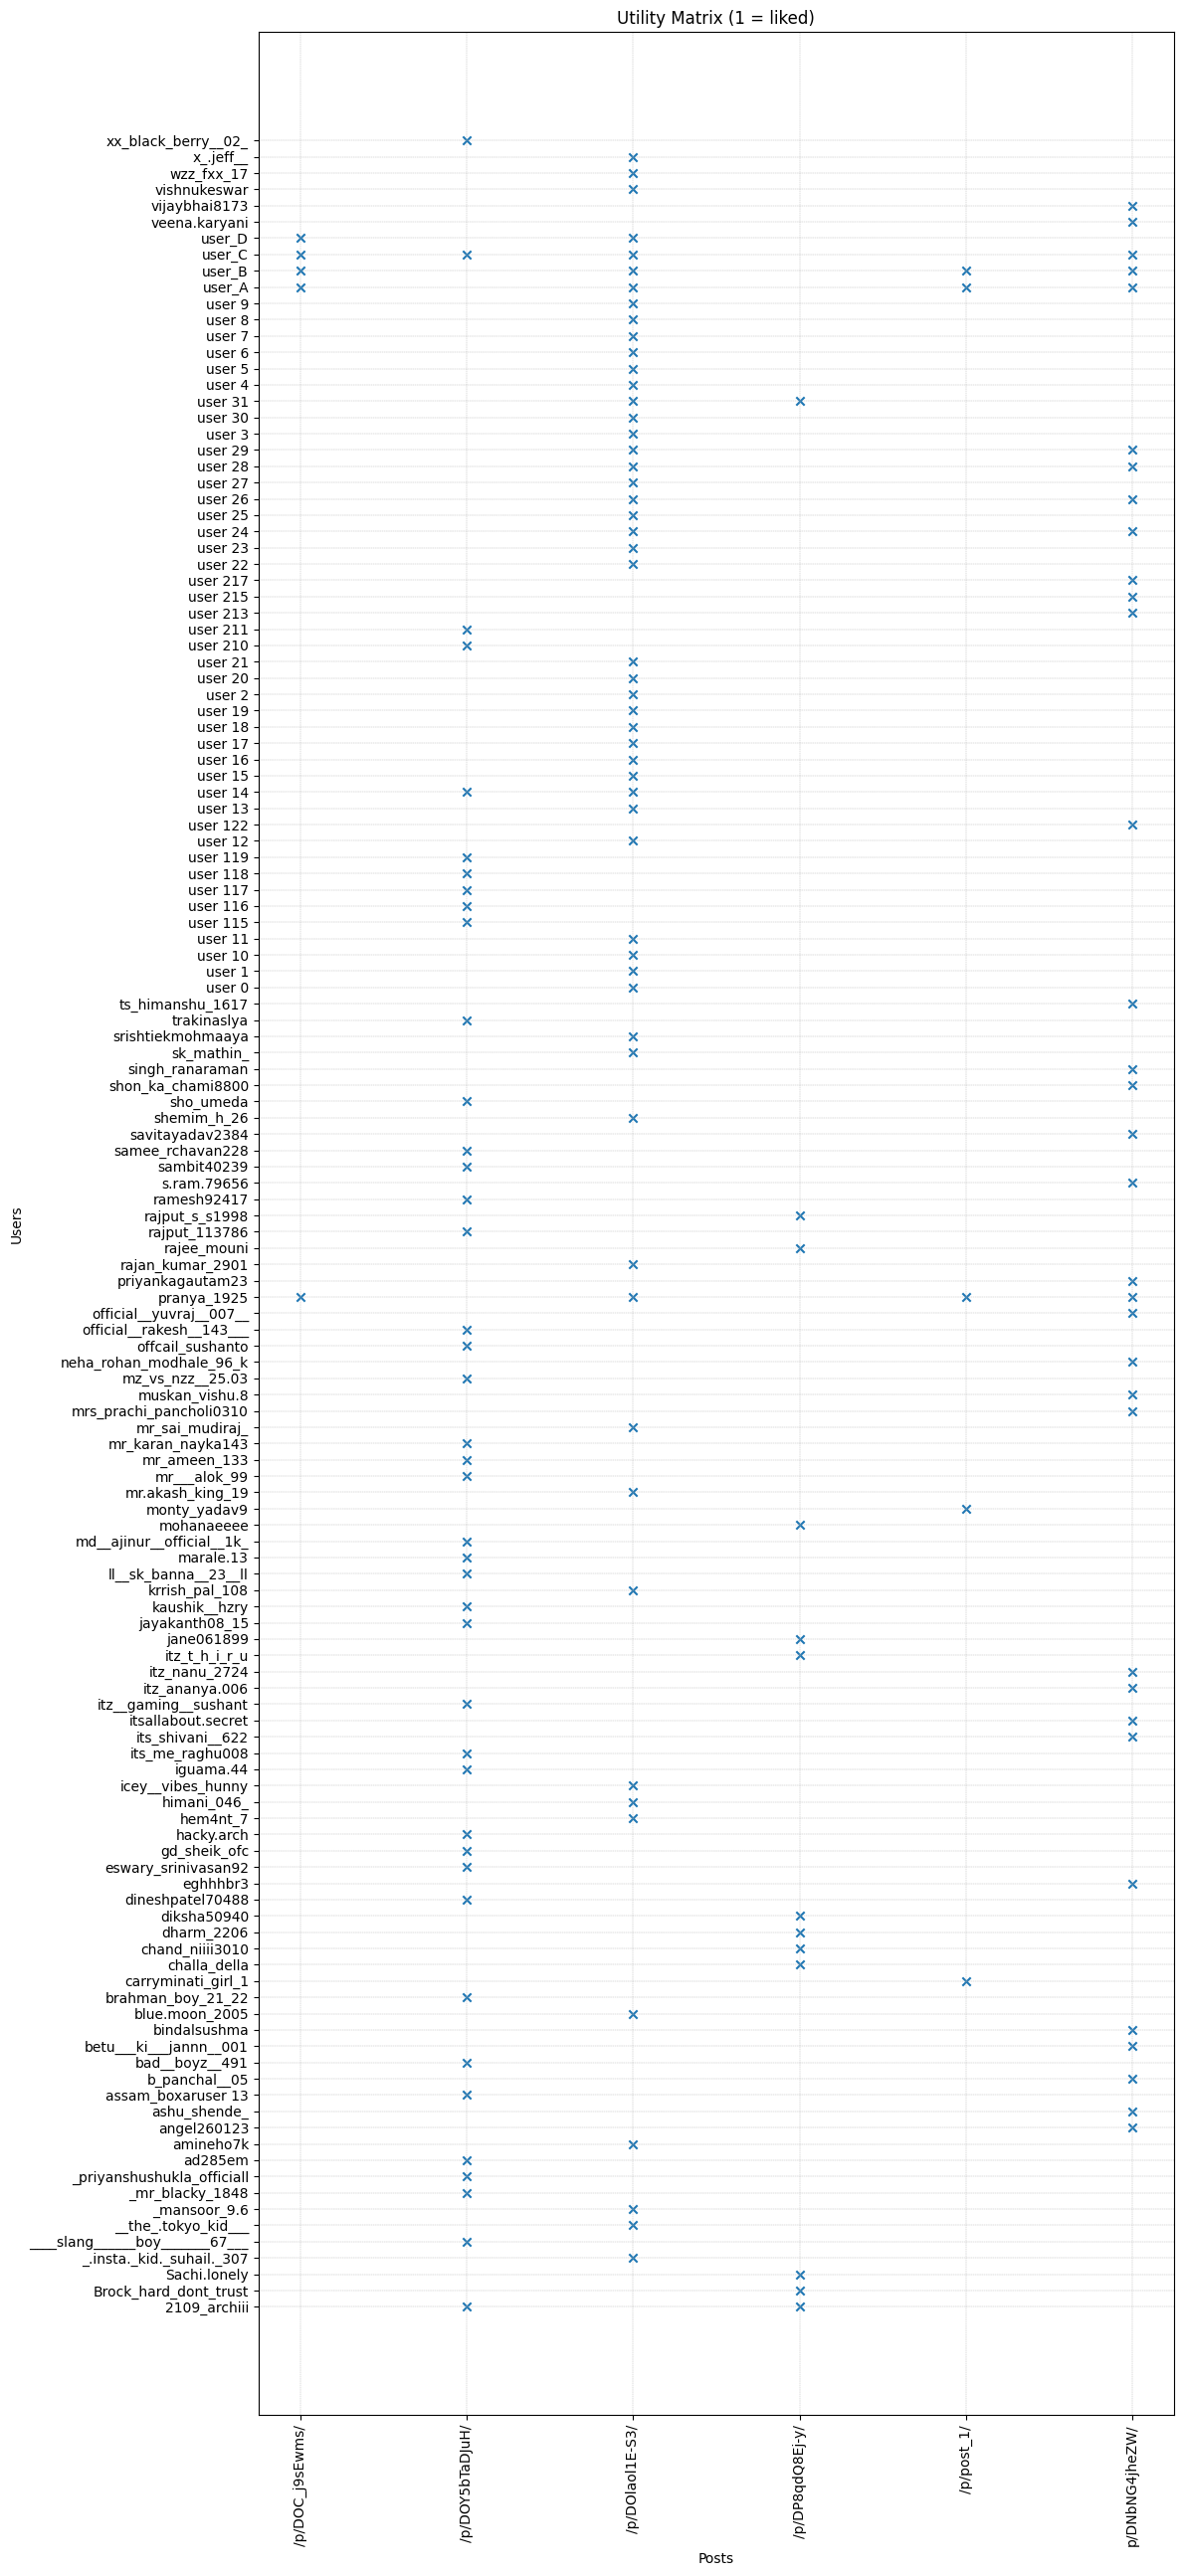

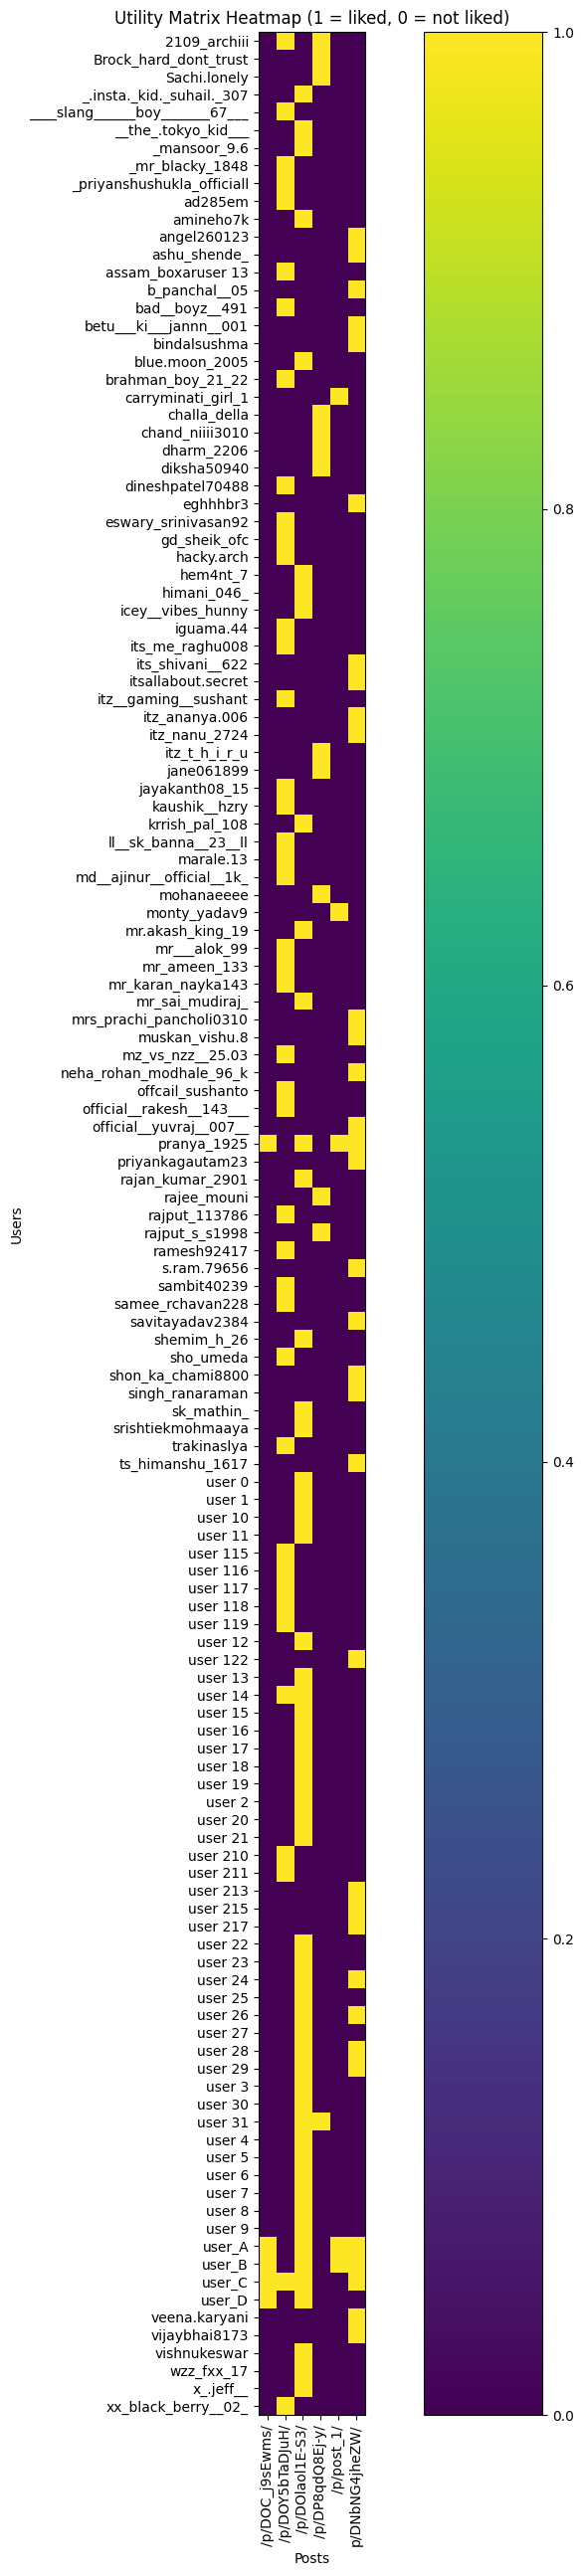

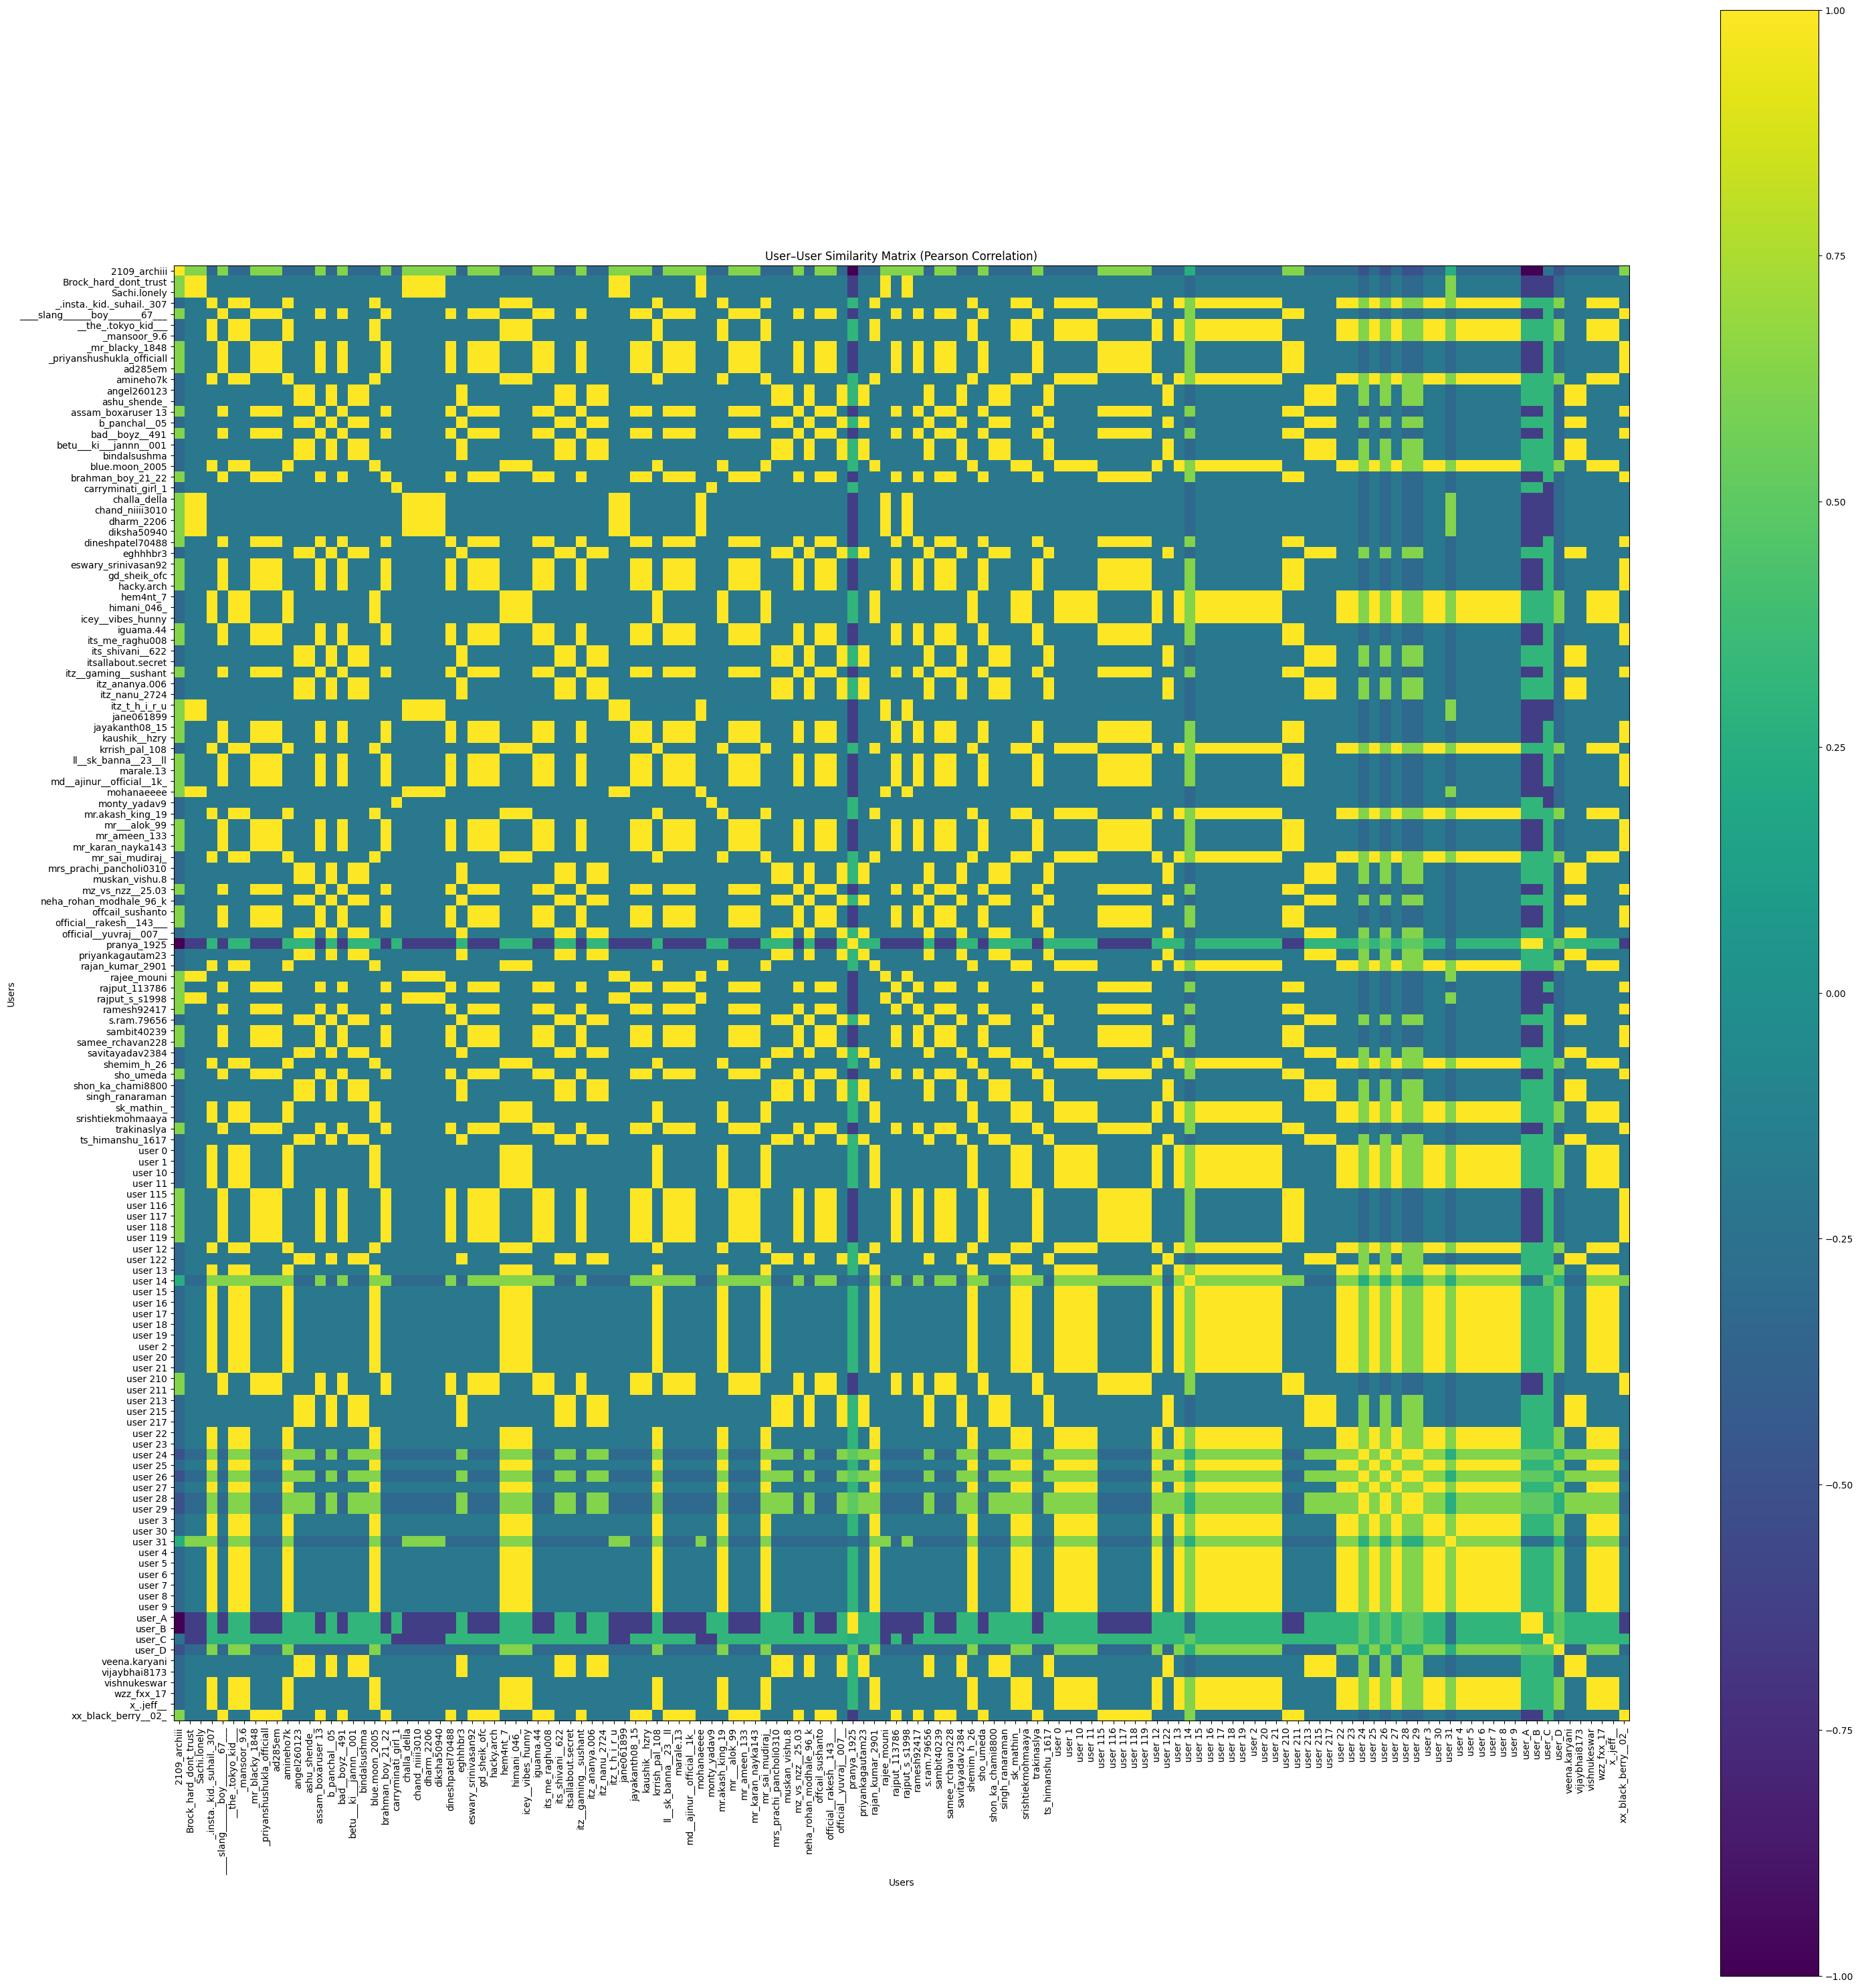

In [95]:
import matplotlib.pyplot as plt

def visualize_utility_scatter(utility_matrix):
    plt.figure(figsize=(12, 26))

    users = list(utility_matrix.index)
    posts = list(utility_matrix.columns)

    x = []
    y = []

    for i, user in enumerate(users):
        for j, post in enumerate(posts):
            if utility_matrix.iloc[i, j] == 1:
                x.append(j)
                y.append(i)

    plt.scatter(x, y, marker='x')

    plt.xticks(range(len(posts)), posts, rotation=90)
    plt.yticks(range(len(users)), users)

    plt.xlabel("Posts")
    plt.ylabel("Users")
    plt.title("Utility Matrix (1 = liked)")
    plt.grid(True, linestyle="--", linewidth=0.3)

    plt.tight_layout()
    plt.show()
utility_matrix = create_utility_matrix(data)
visualize_utility_scatter(utility_matrix)
def visualize_utility_heatmap(utility_matrix):
    plt.figure(figsize=(12, 26))

    plt.imshow(utility_matrix.values)

    plt.xticks(range(utility_matrix.shape[1]), utility_matrix.columns, rotation=90)
    plt.yticks(range(utility_matrix.shape[0]), utility_matrix.index)

    plt.xlabel("Posts")
    plt.ylabel("Users")
    plt.title("Utility Matrix Heatmap (1 = liked, 0 = not liked)")

    plt.colorbar()
    plt.tight_layout()
    plt.show()
visualize_utility_heatmap(utility_matrix)
def visualize_similarity_matrix(similarity_matrix):
    plt.figure(figsize=(30, 30))

    plt.imshow(similarity_matrix.values, vmin=-1, vmax=1)

    plt.xticks(range(similarity_matrix.shape[1]), similarity_matrix.columns, rotation=90)
    plt.yticks(range(similarity_matrix.shape[0]), similarity_matrix.index)

    plt.xlabel("Users")
    plt.ylabel("Users")
    plt.title("User–User Similarity Matrix (Pearson Correlation)")

    plt.colorbar()
    plt.tight_layout()
    plt.show()
user_similarity = get_user_similarity(utility_matrix)
visualize_similarity_matrix(user_similarity)



Total posts: 6
Total likes (item estimate): 154
Average likes per post: 25.67


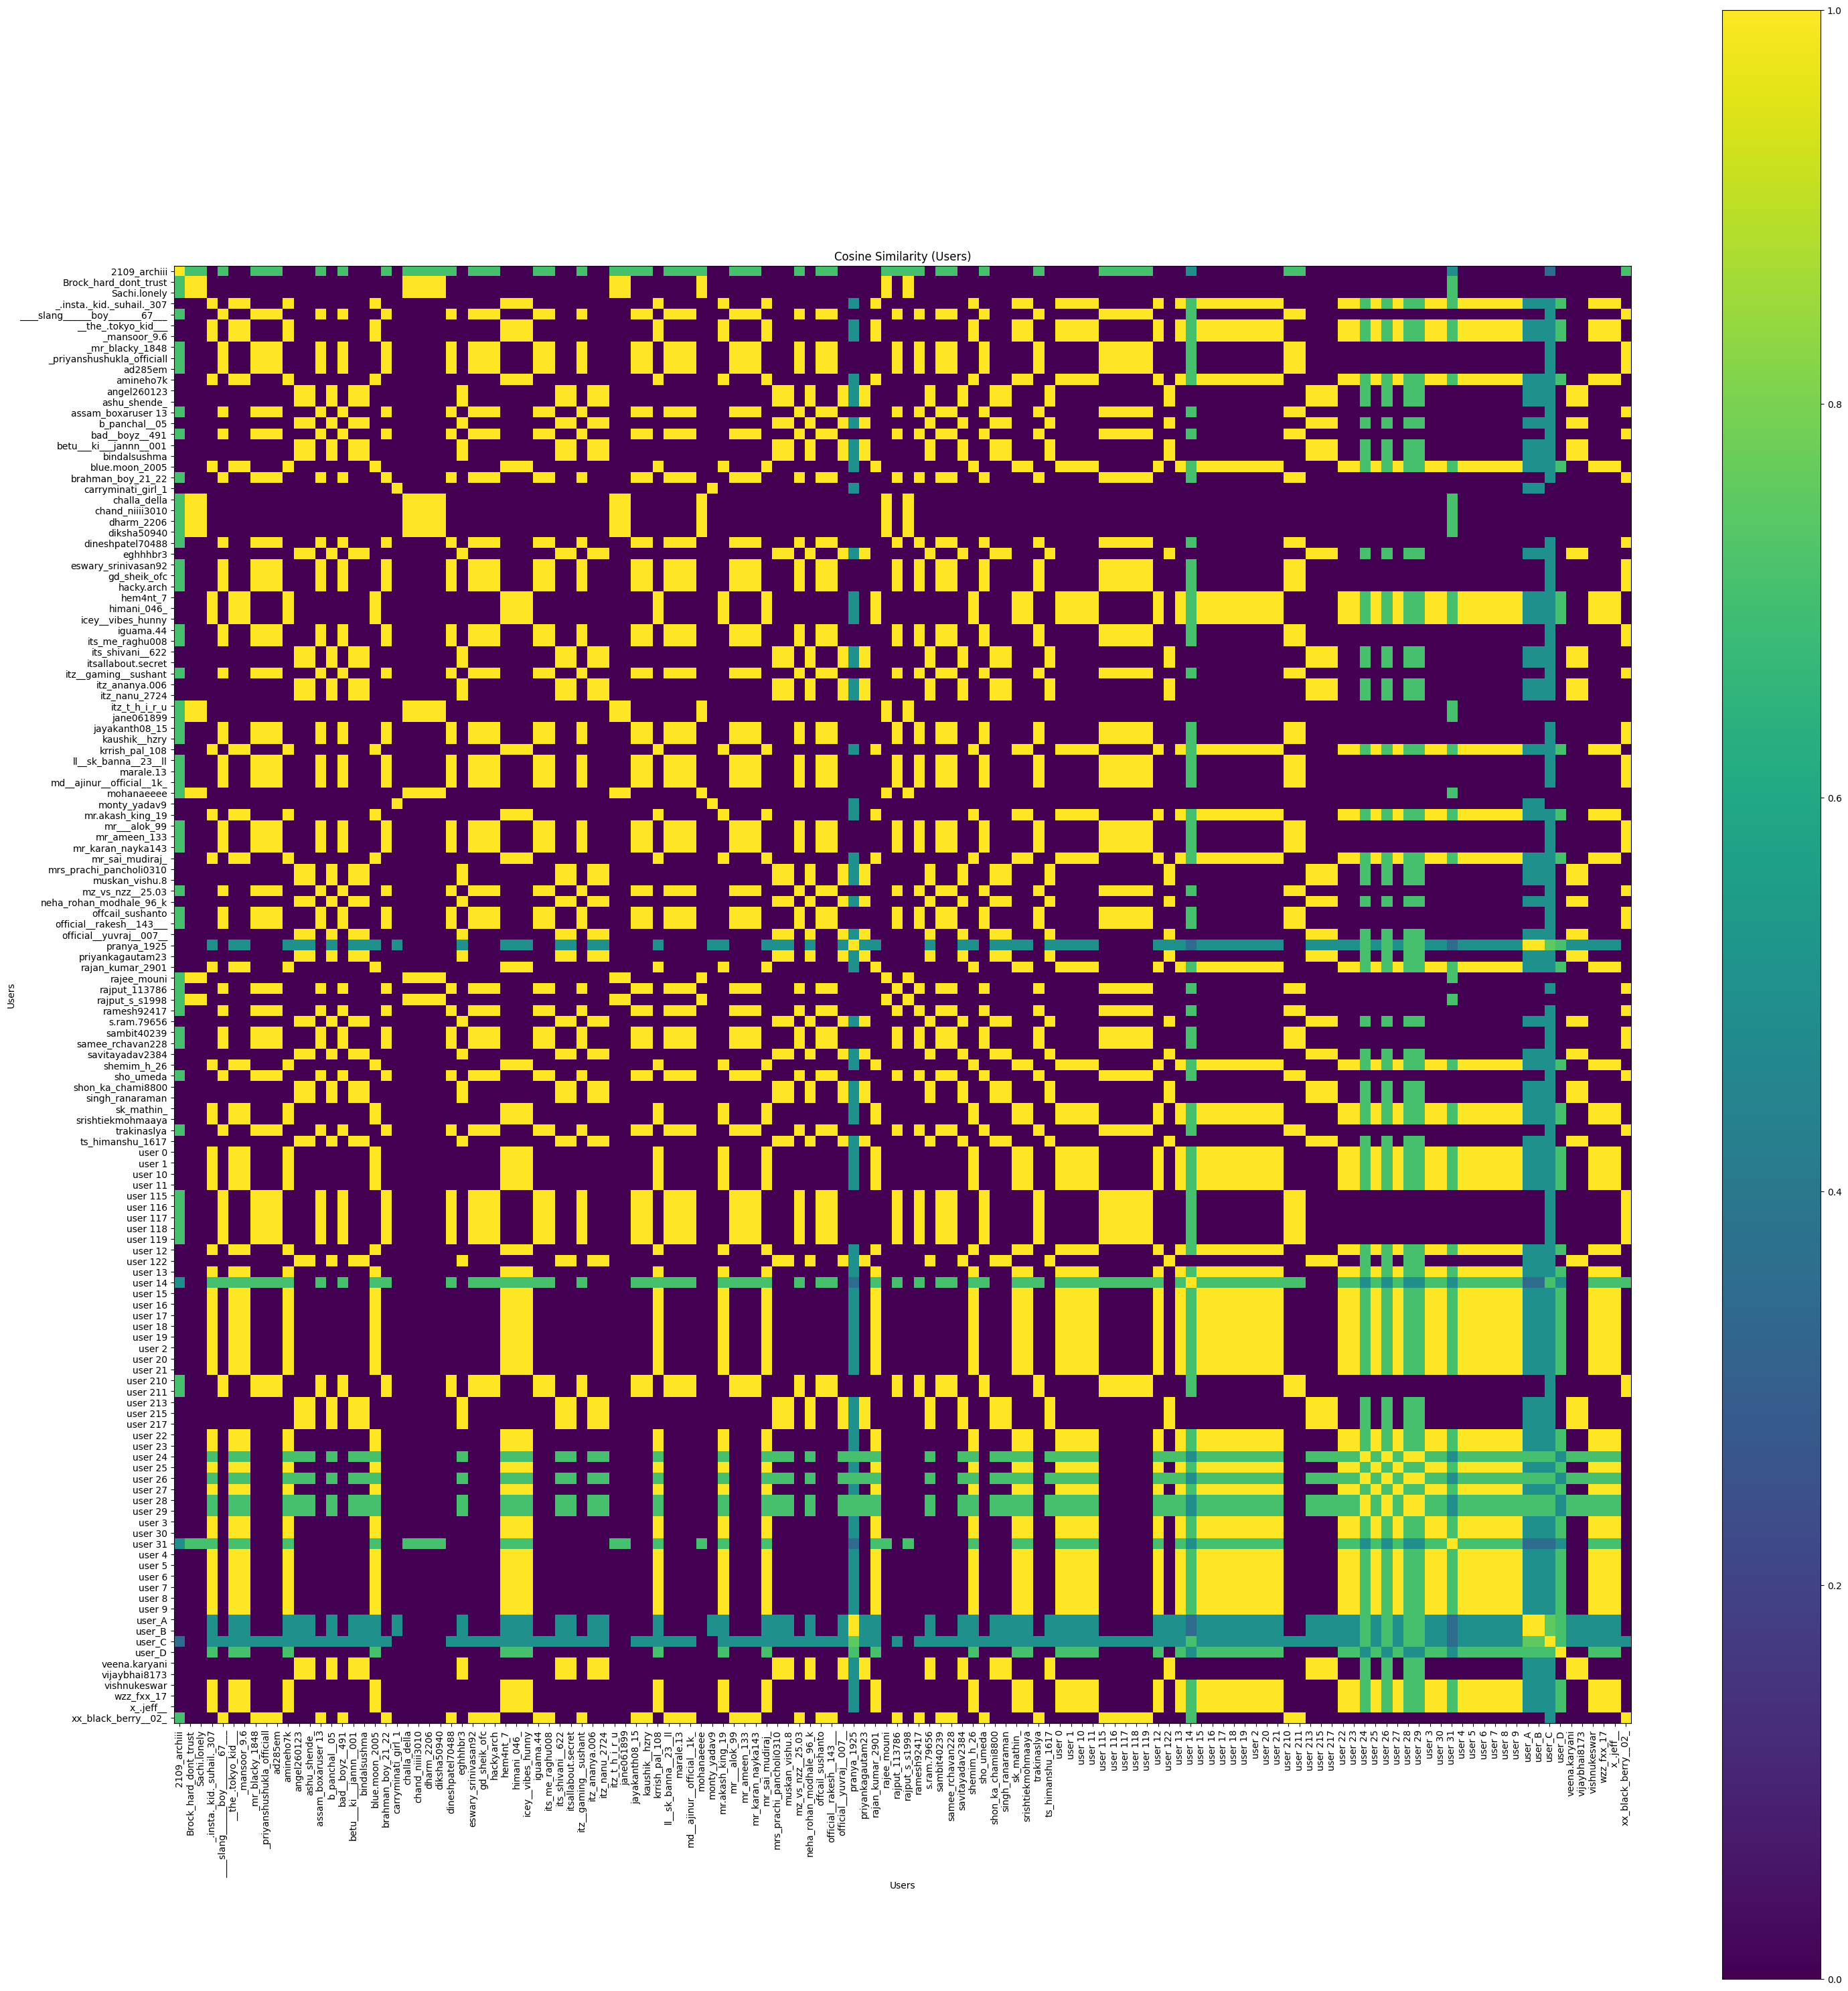

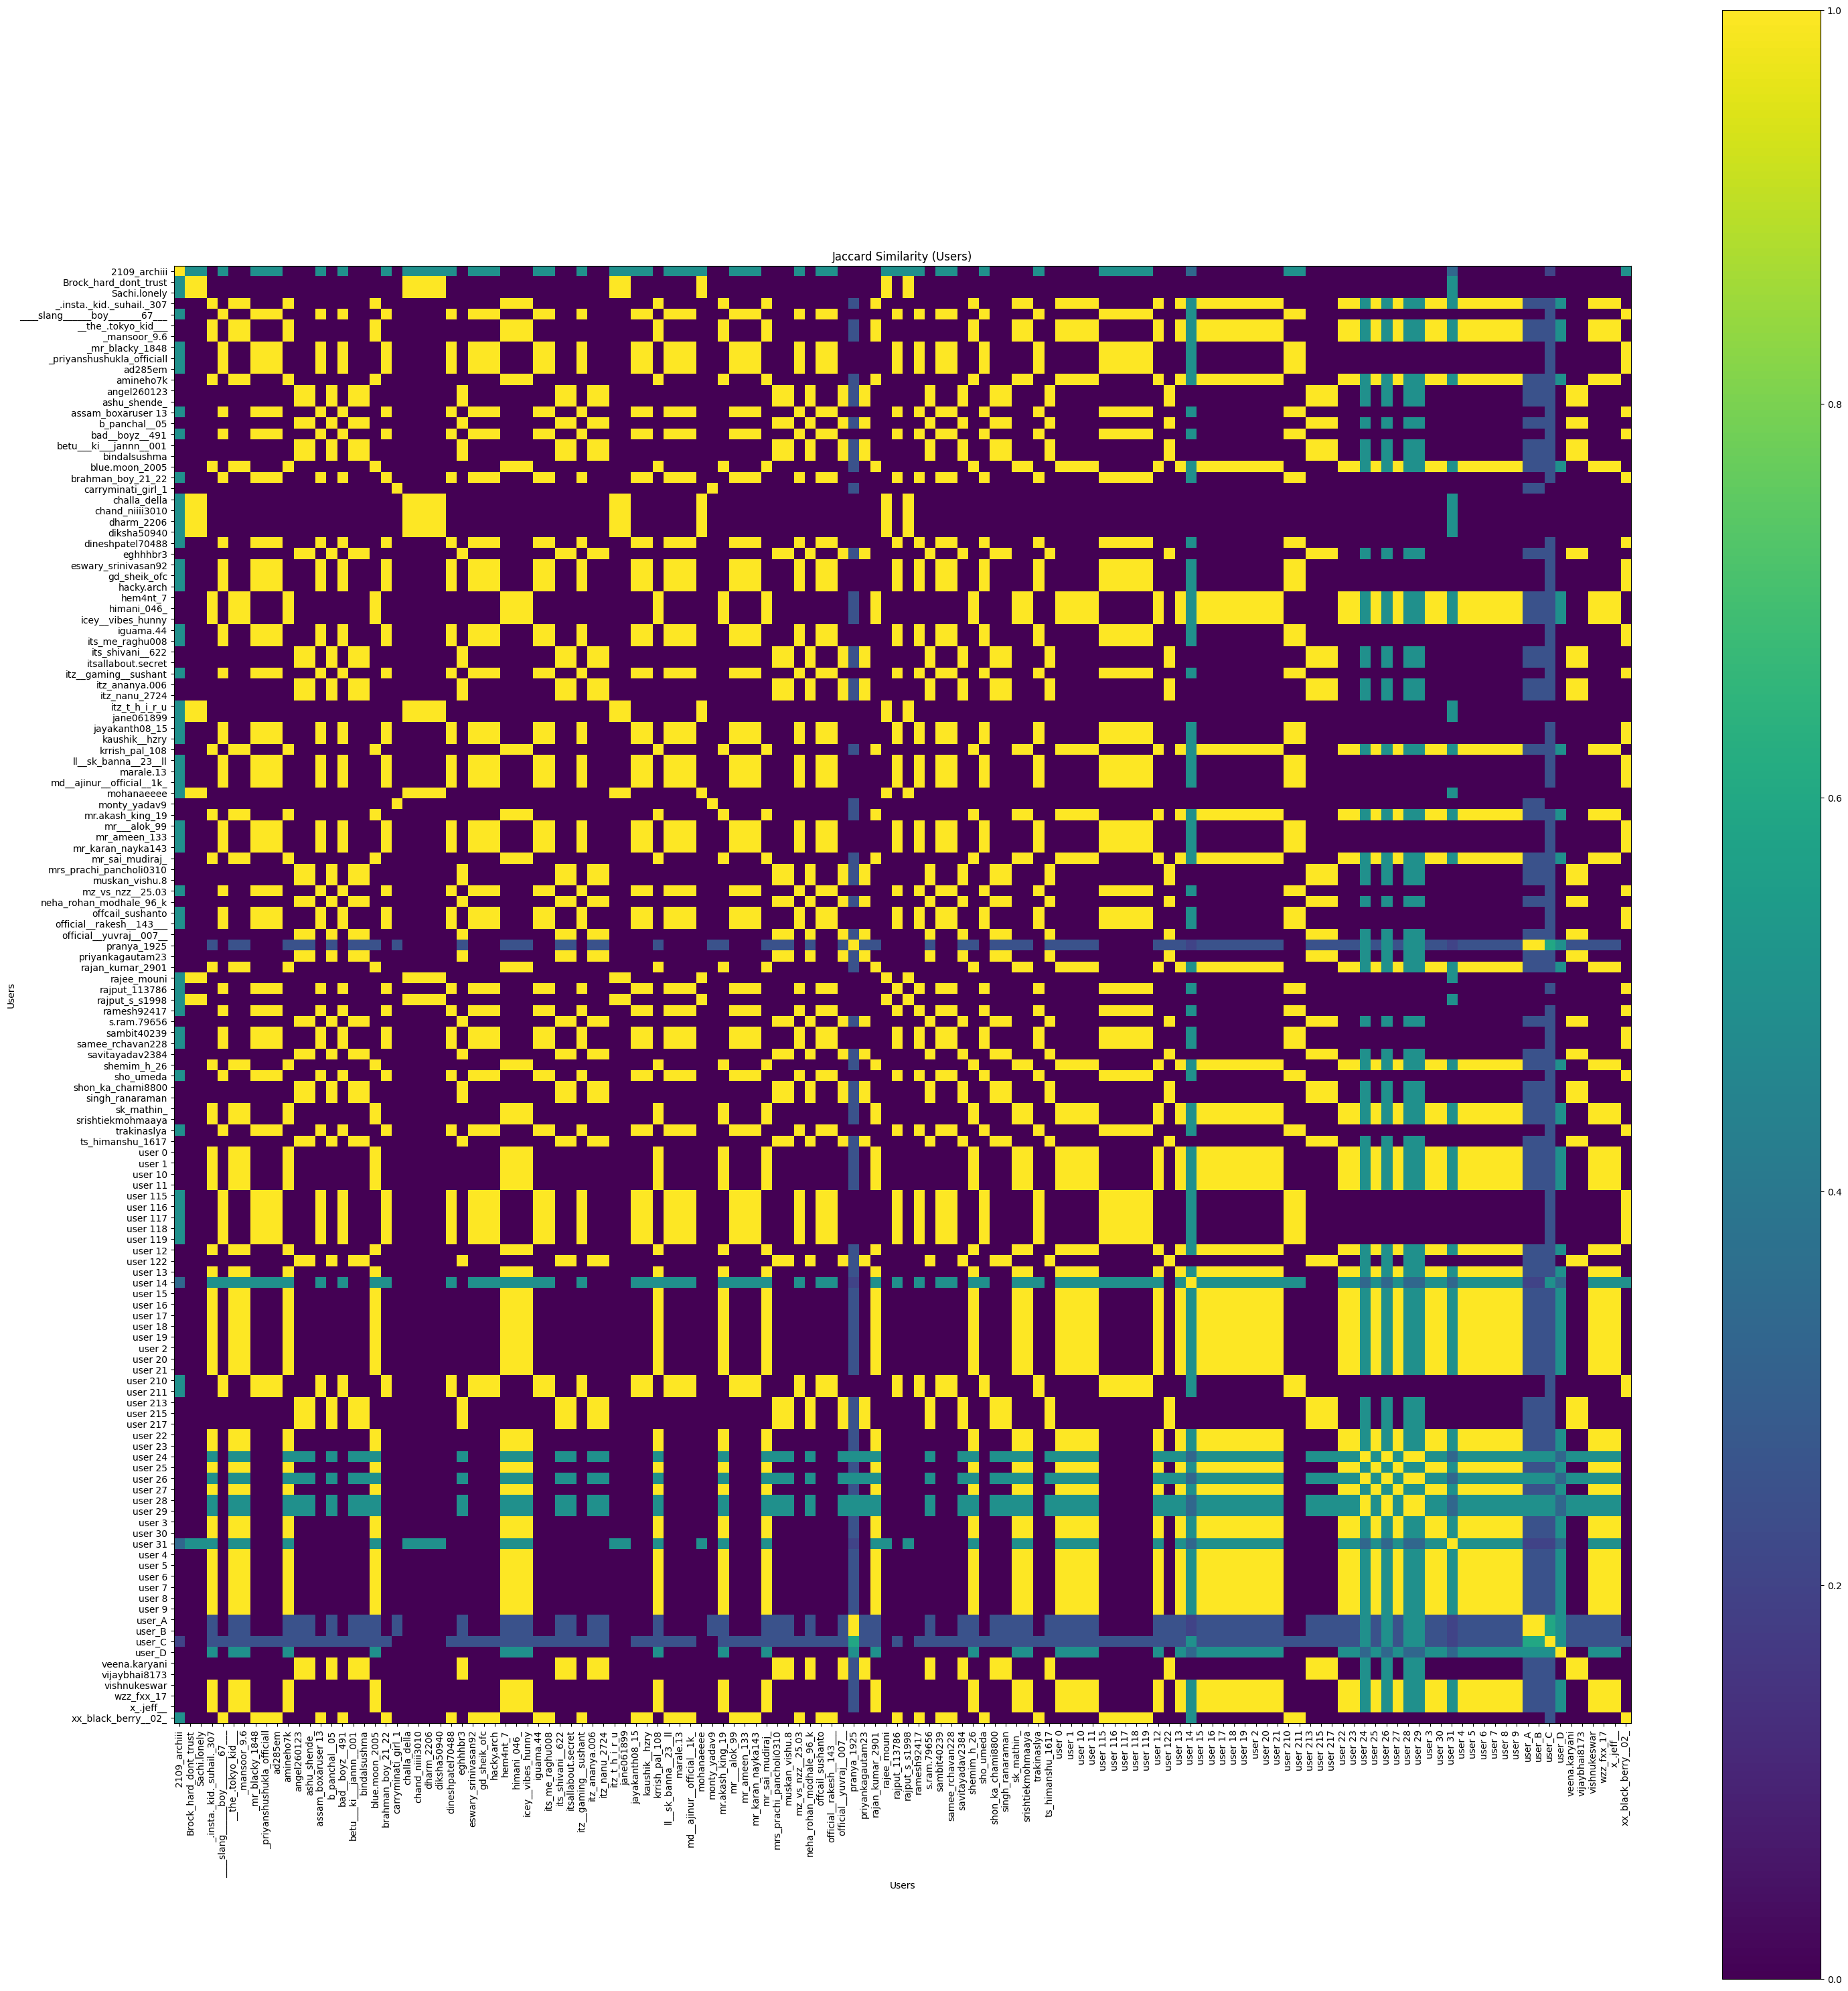

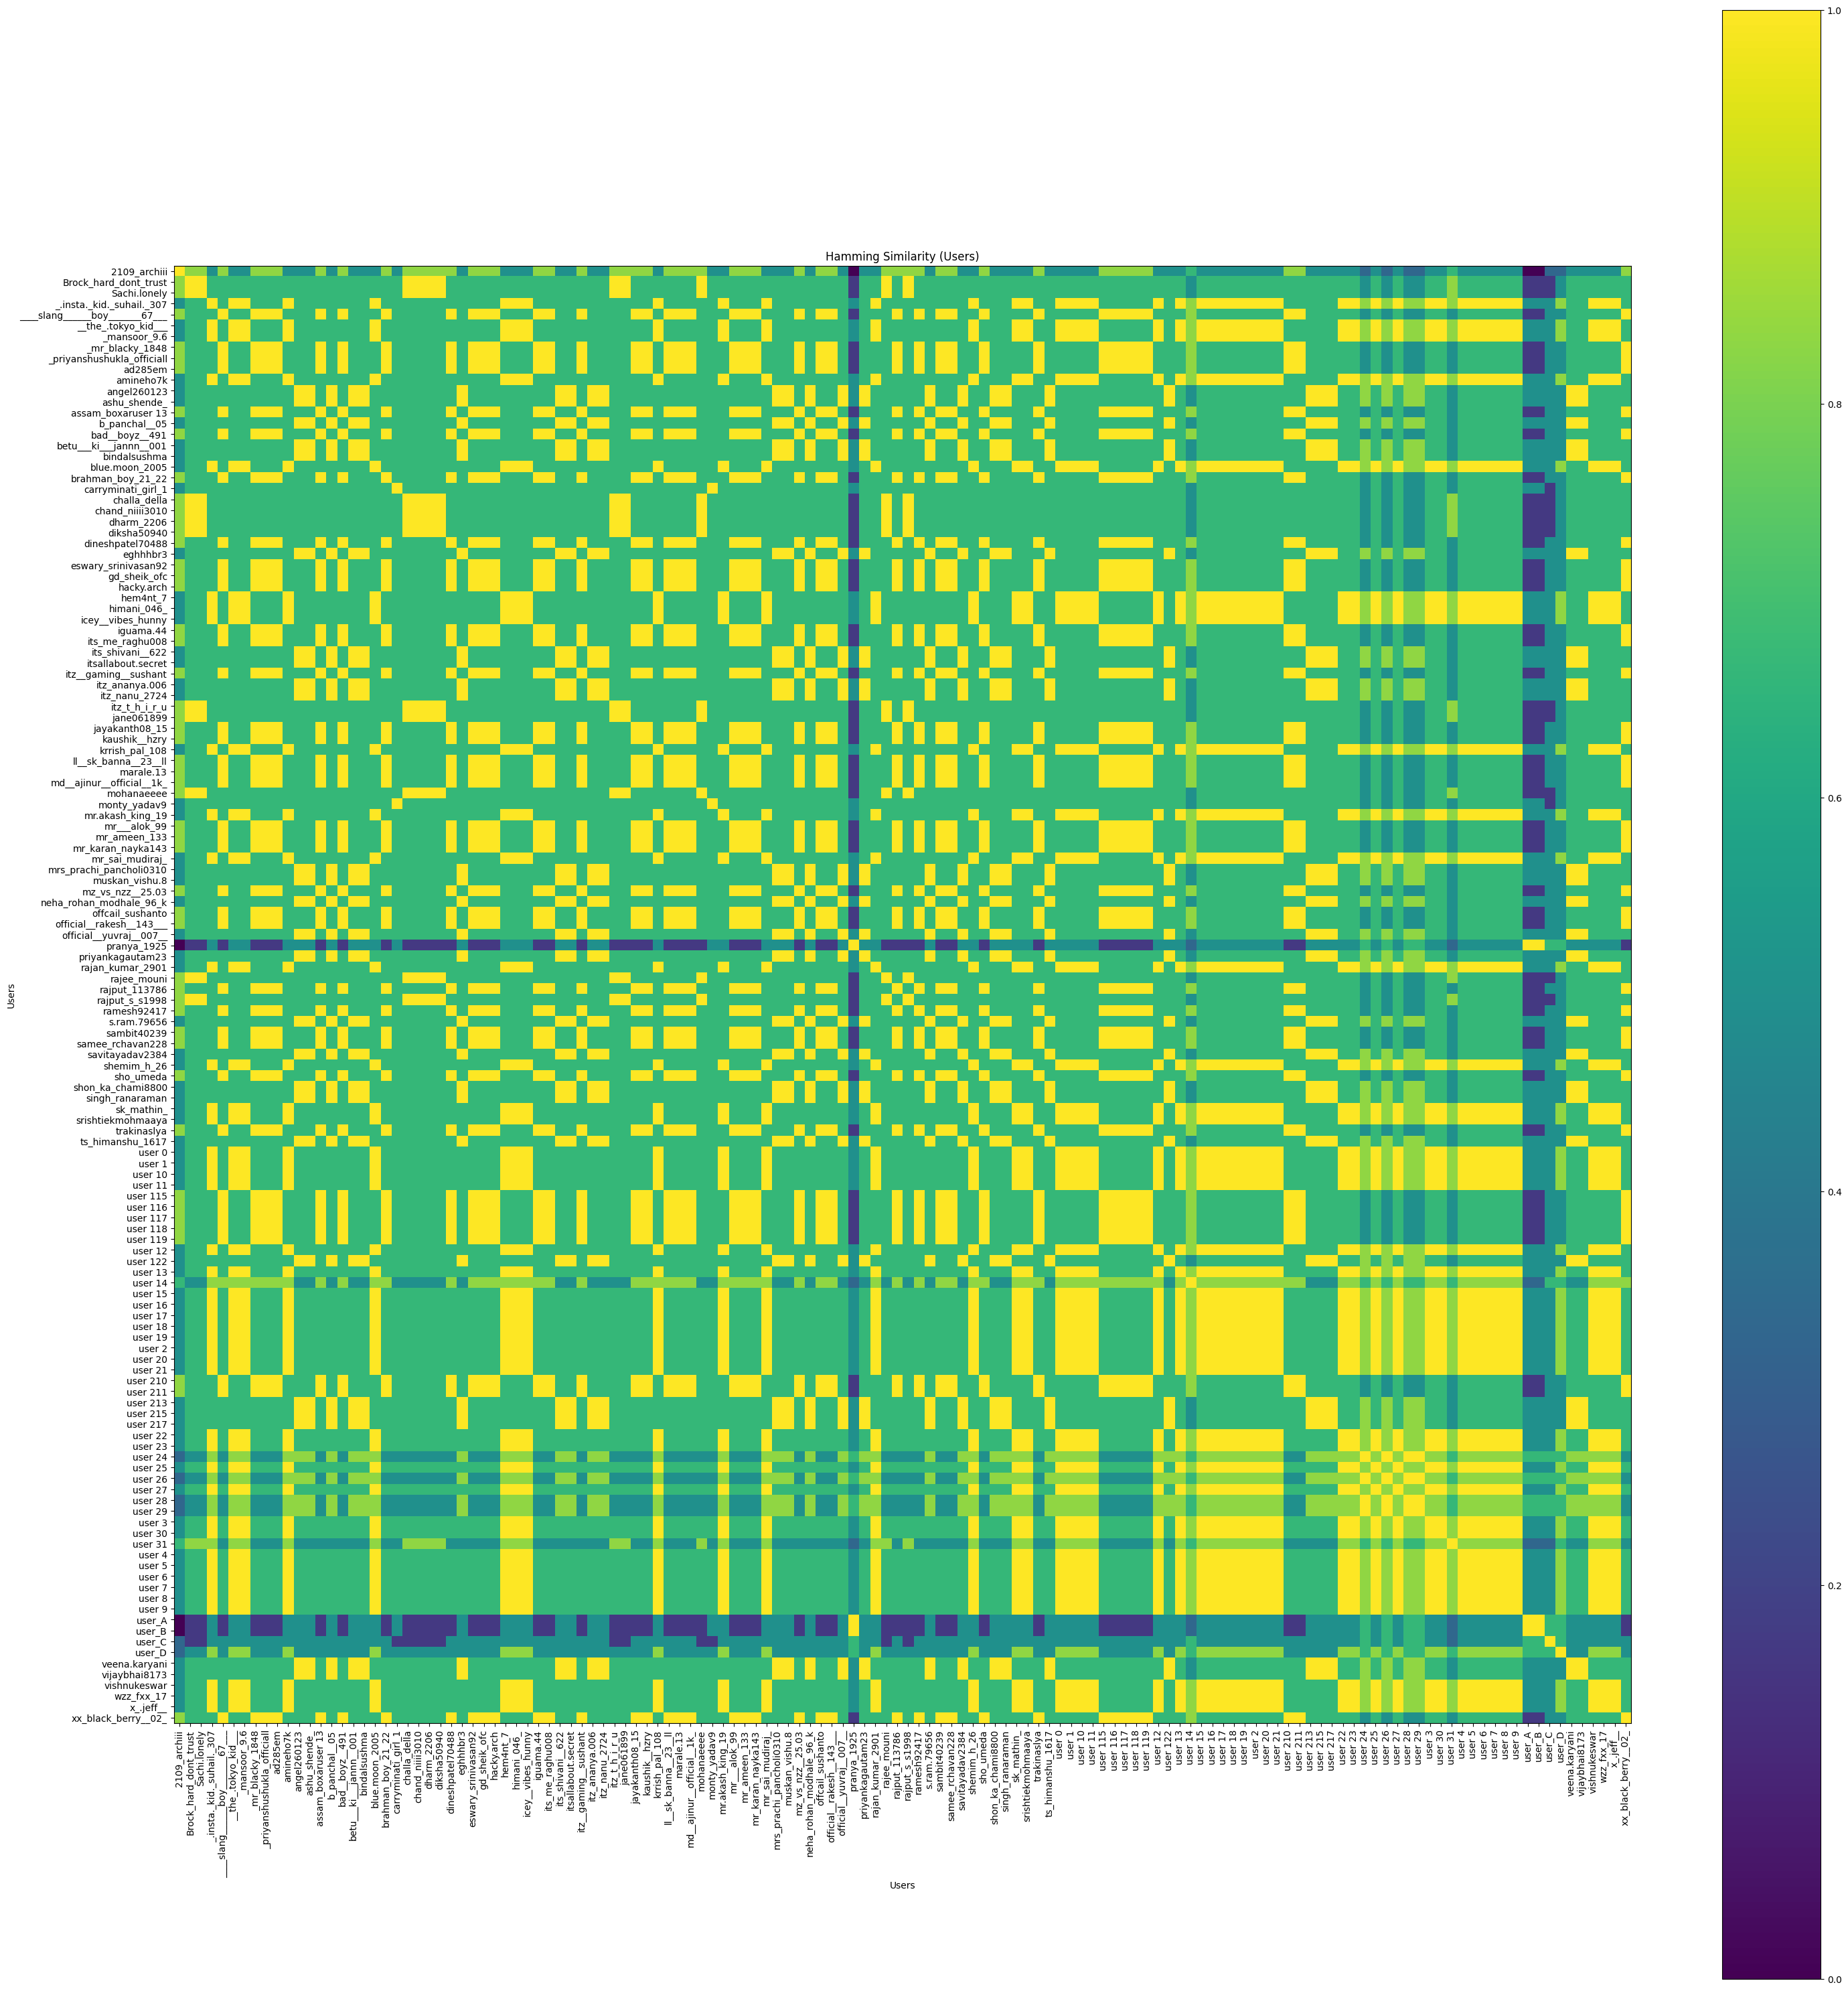

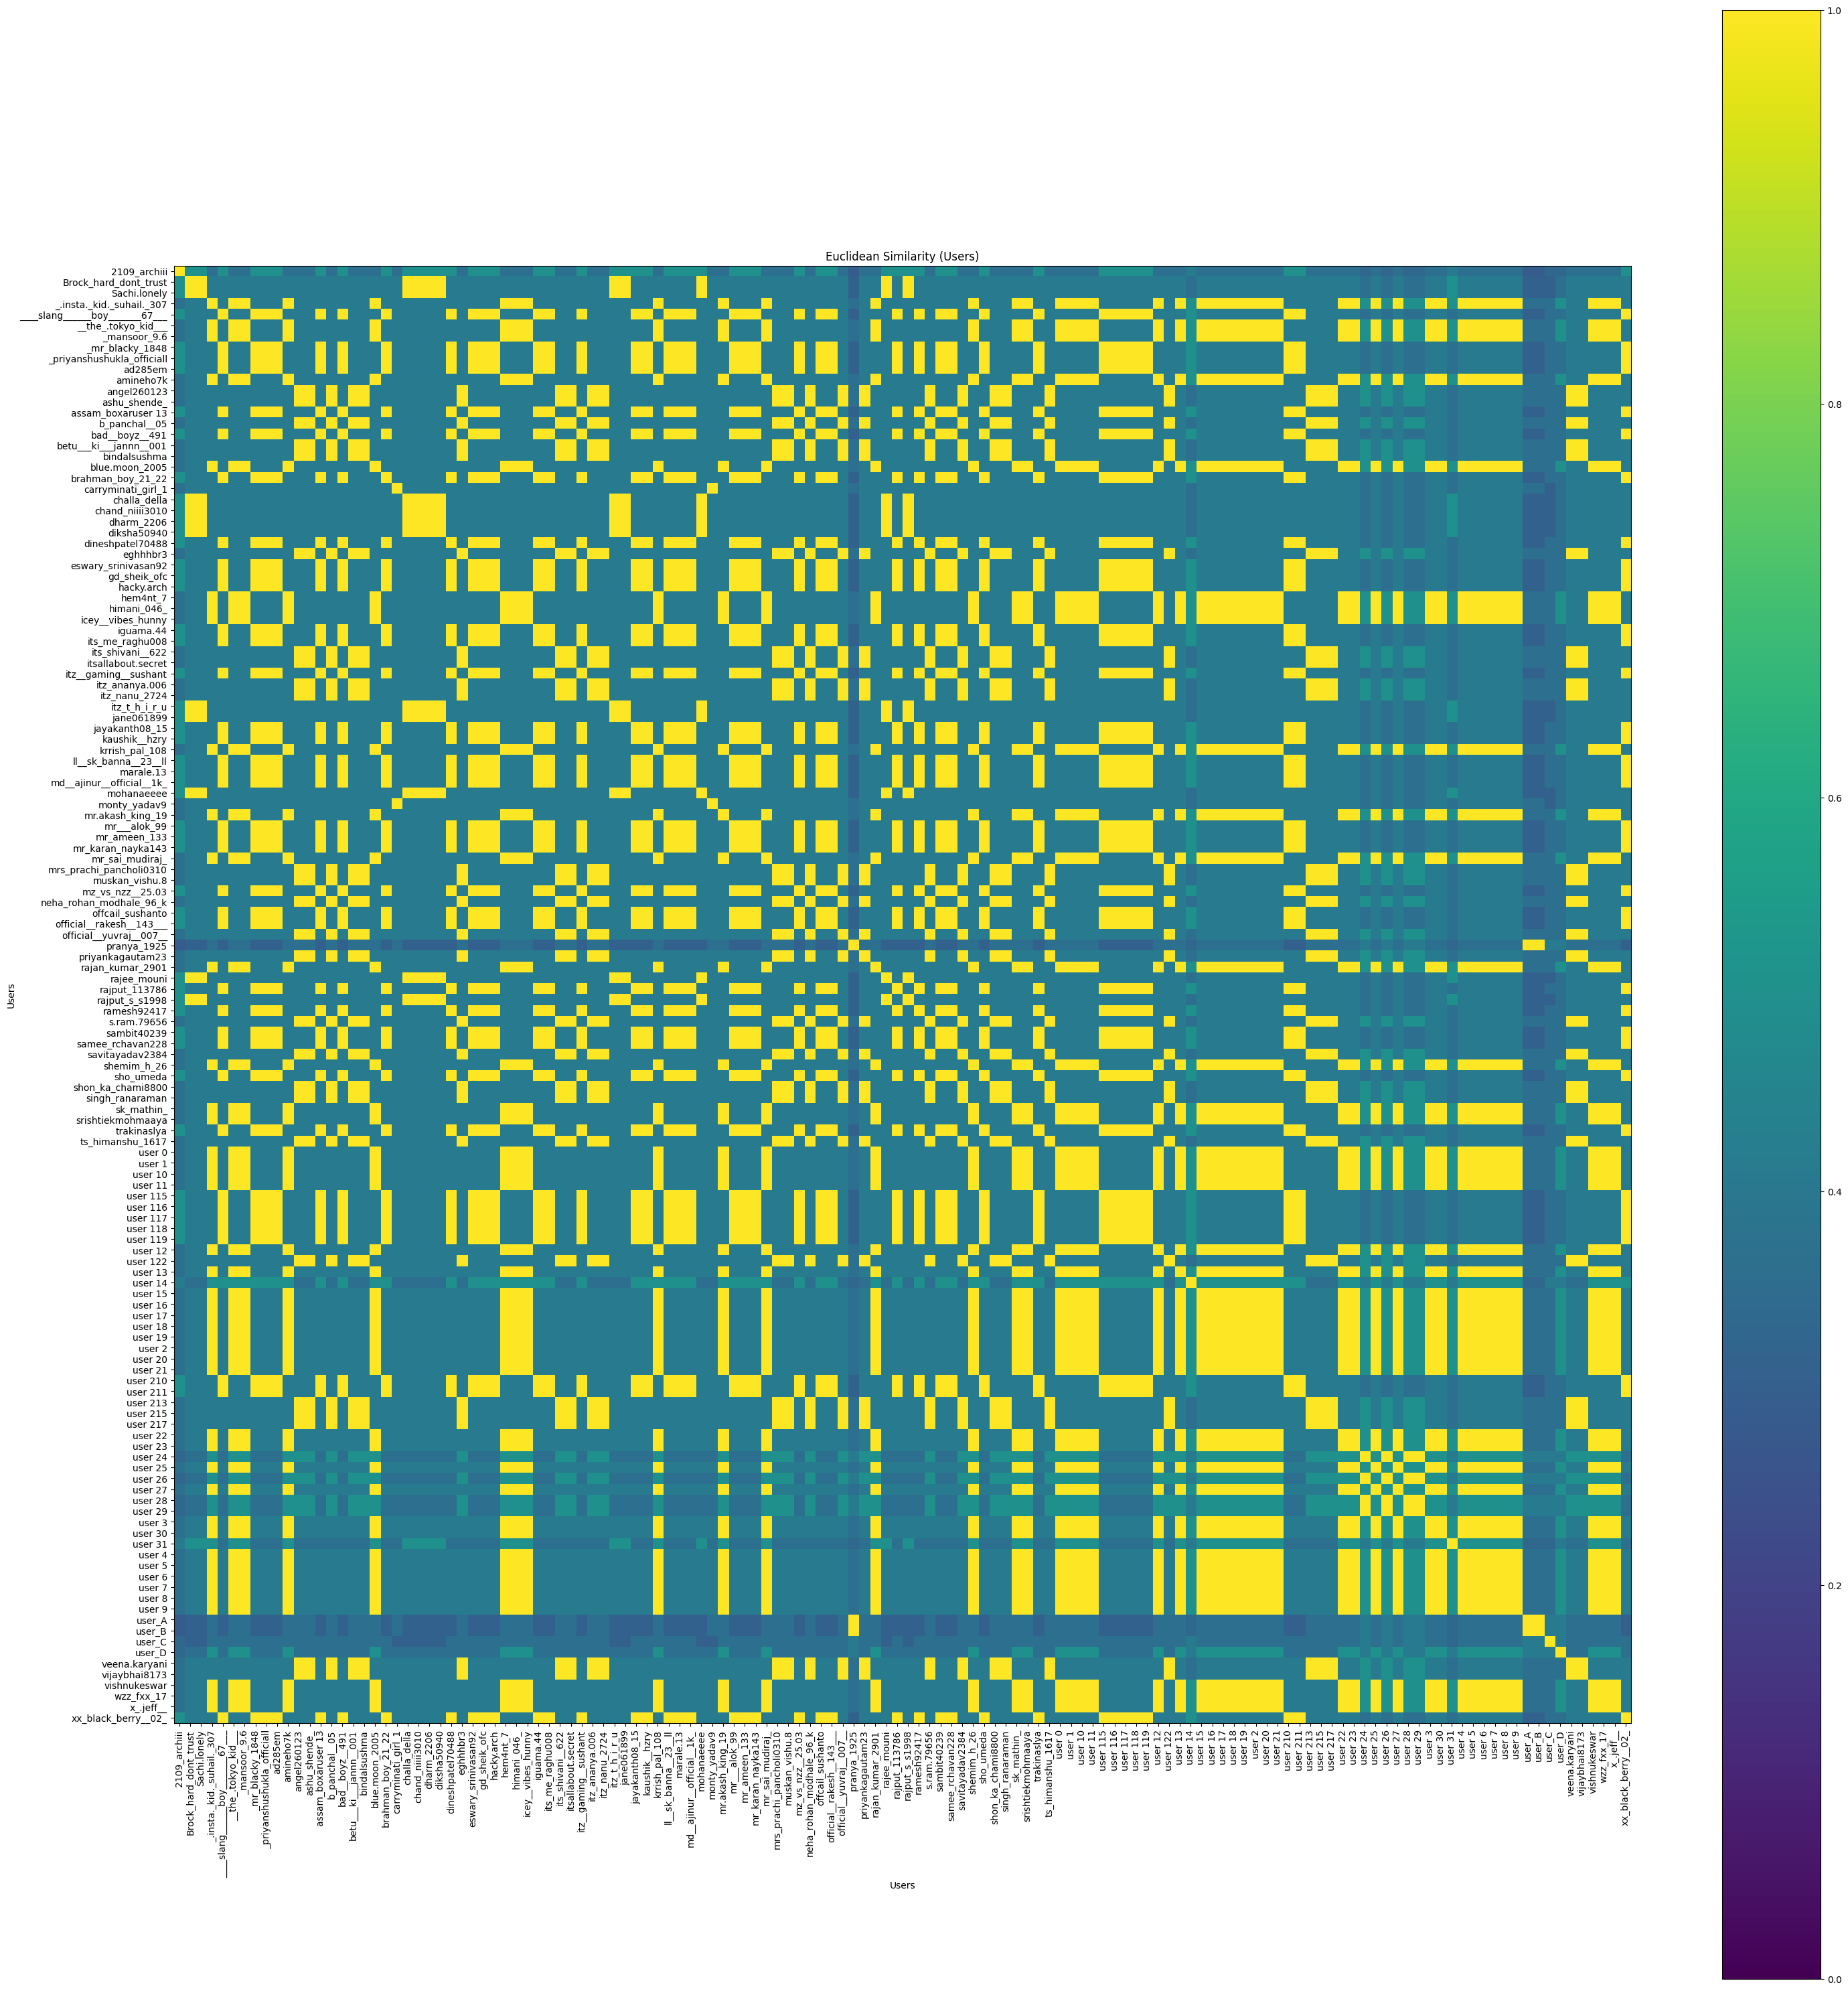

In [96]:
import numpy as np
import pandas as pd

# ---------- 1. COSINE SIMILARITY ----------
def cosine_similarity(utility_matrix):
    A = utility_matrix.values
    dot = A @ A.T
    norm = np.linalg.norm(A, axis=1)
    sim = dot / np.outer(norm, norm)
    return pd.DataFrame(sim, index=utility_matrix.index, columns=utility_matrix.index)

# ---------- 2. JACCARD SIMILARITY ----------
def jaccard_similarity(utility_matrix):
    A = utility_matrix.values
    intersection = A @ A.T
    row_sums = A.sum(axis=1).reshape(-1, 1)
    union = row_sums + row_sums.T - intersection
    sim = intersection / union
    return pd.DataFrame(sim, index=utility_matrix.index, columns=utility_matrix.index)

# ---------- 3. HAMMING SIMILARITY ----------
def hamming_similarity(utility_matrix):
    A = utility_matrix.values
    sim = []
    for u in A:
        row = []
        for v in A:
            eq = np.sum(u == v)
            row.append(eq / len(u))
        sim.append(row)
    return pd.DataFrame(sim, index=utility_matrix.index, columns=utility_matrix.index)

# ---------- 4. EUCLIDEAN SIMILARITY ----------
def euclidean_similarity(utility_matrix):
    A = utility_matrix.values
    sim = []
    for u in A:
        row = []
        for v in A:
            dist = np.linalg.norm(u - v)
            row.append(1 / (1 + dist))
        sim.append(row)
    return pd.DataFrame(sim, index=utility_matrix.index, columns=utility_matrix.index)
import matplotlib.pyplot as plt

def visualize_similarity(similarity_matrix, title="Similarity Matrix"):
    plt.figure(figsize=(30, 30))
    plt.imshow(similarity_matrix.values, vmin=0, vmax=1)

    plt.xticks(range(similarity_matrix.shape[1]), similarity_matrix.columns, rotation=90)
    plt.yticks(range(similarity_matrix.shape[0]), similarity_matrix.index)

    plt.xlabel("Users")
    plt.ylabel("Users")
    plt.title(title)

    plt.colorbar()
    plt.tight_layout()
    plt.show()
utility_matrix = create_utility_matrix(data)

cos_sim = cosine_similarity(utility_matrix)
jac_sim = jaccard_similarity(utility_matrix)
ham_sim = hamming_similarity(utility_matrix)
euc_sim = euclidean_similarity(utility_matrix)

visualize_similarity(cos_sim, "Cosine Similarity (Users)")
visualize_similarity(jac_sim, "Jaccard Similarity (Users)")
visualize_similarity(ham_sim, "Hamming Similarity (Users)")
visualize_similarity(euc_sim, "Euclidean Similarity (Users)")


In [101]:
def reservoir_sample(stream, k):
    """
    Performs Reservoir Sampling (Algorithm R) on a stream.
    """
    reservoir = []
    for i, item in enumerate(stream):
        if i < k:
            # Fill the reservoir with the first k items
            reservoir.append(item)
        else:
            # For all subsequent items...
            # Generate a random integer j between 0 and i (inclusive)
            j = random.randint(0, i)

            # If j is less than k, replace the item at index j
            # in the reservoir with the new item.
            # The probability of this is k / (i+1).
            if j < k:
                reservoir[j] = item
    return reservoir

print("\n--- 2. Reservoir Sampling ---")
# Our 'stream' is the list of post dictionaries
post_stream = data
k = 3

sample = reservoir_sample(post_stream, k)

print(f"Run 1: A random sample of {k} posts (will vary on each run):")
for post in sample:
    print(f"- {post['post_id']} by {post['user_id']}")


--- 2. Reservoir Sampling ---
Run 1: A random sample of 3 posts (will vary on each run):
- /p/DP8qdQ8Ej-y/ by _story_thinker
- p/DNbNG4jheZW/ by theofficial_wolf_
- /p/DOlaol1E-S3/ by relatable_guy08


In [102]:
#Run 2
sample = reservoir_sample(post_stream, k)

print(f"Run 2: A random sample of {k} posts (will vary on each run):")
for post in sample:
    print(f"- {post['post_id']} by {post['user_id']}")

Run 2: A random sample of 3 posts (will vary on each run):
- /p/post_1/ by lots_of_pain_01
- p/DNbNG4jheZW/ by theofficial_wolf_
- /p/DOY5bTaDJuH/ by mrcai320


In [104]:
print("\n--- 3. Bloom Filter ---")

# Best to estimate the number of items and desired error rate
num_items = 20  # (154 is average.)
error_rate = 0.05  # 5% chance of false positives

bloom = BloomFilter(expected_insertions=num_items, err_rate=error_rate)

print(f"Created Bloom Filter with size: {bloom.num_of_bits(expected_insertions=num_items, err_rate=error_rate)} bits")

# Add all user-like pairs to the filter
print("Adding liked items to filter...")
for post in data:
    for user in post['liked_by']:
        item_key = f"{user}_liked_{post['post_id']}"
        bloom.put(item_key)

# --- Test for items ---

# Test 1: An item we KNOW is in the set (True Negative is impossible)
item_present = "user_A_liked_/p/post_2/"
print(f"Check 1 (IS present): '{item_present}' in filter? {'YES' if item_present in bloom else 'NO'}")

# Test 2: An item we KNOW is NOT in the set (True Negative)
item_absent = "user_meow_liked_/p/post_99/"
print(f"Check 2 (IS NOT present): '{item_absent}' in filter? {'YES (False Positive!)' if item_absent in bloom else 'NO'}")

# Test 3: Another item NOT in the set (might be a false positive)
item_absent_2 = "monty_yadav9_liked_/p/post_2/"
print(f"Check 3 (IS NOT present): '{item_absent_2}' in filter? {'YES (False Positive!)' if item_absent_2 in bloom else 'NO'}")


--- 3. Bloom Filter ---
Created Bloom Filter with size: 124 bits
Adding liked items to filter...
Check 1 (IS present): 'user_A_liked_/p/post_2/' in filter? YES
Check 2 (IS NOT present): 'user_meow_liked_/p/post_99/' in filter? YES (False Positive!)
Check 3 (IS NOT present): 'monty_yadav9_liked_/p/post_2/' in filter? YES (False Positive!)


The reason bloom filter is giving False Positive is because its size compared to the number of items is too low 20<<150. Reducing size of data to 20 or increasing size of bloom filter to 90 gives no false positives.

In [106]:
print("\n--- 3. Bloom Filter ---")

# Best to estimate the number of items and desired error rate
num_items = 90  # (154 is average.)
error_rate = 0.05  # 5% chance of false positives

bloom = BloomFilter(expected_insertions=num_items, err_rate=error_rate)

print(f"Created Bloom Filter with size: {bloom.num_of_bits(expected_insertions=num_items, err_rate=error_rate)} bits")

# Add all user-like pairs to the filter
print("Adding liked items to filter...")
for post in data:
    for user in post['liked_by']:
        item_key = f"{user}_liked_{post['post_id']}"
        bloom.put(item_key)

# --- Test for items ---

# Test 1: An item we KNOW is in the set (True Negative is impossible)
item_present = "user_A_liked_/p/post_2/"
print(f"Check 1 (IS present): '{item_present}' in filter? {'YES' if item_present in bloom else 'NO'}")

# Test 2: An item we KNOW is NOT in the set (True Negative)
item_absent = "user_meow_liked_/p/post_99/"
print(f"Check 2 (IS NOT present): '{item_absent}' in filter? {'YES (False Positive!)' if item_absent in bloom else 'NO'}")

# Test 3: Another item NOT in the set (might be a false positive)
item_absent_2 = "monty_yadav9_liked_/p/post_2/"
print(f"Check 3 (IS NOT present): '{item_absent_2}' in filter? {'YES (False Positive!)' if item_absent_2 in bloom else 'NO'}")


--- 3. Bloom Filter ---
Created Bloom Filter with size: 561 bits
Adding liked items to filter...
Check 1 (IS present): 'user_A_liked_/p/post_2/' in filter? YES
Check 2 (IS NOT present): 'user_meow_liked_/p/post_99/' in filter? NO
Check 3 (IS NOT present): 'monty_yadav9_liked_/p/post_2/' in filter? NO


In [105]:
data1 = [
    {
        'user_id': 'lots_of_pain_01',
        'post_id': '/p/post_1/',
        'text': 'Error 🥀💔 #SadReels...',
        'liked_by': ['monty_yadav9', 'carryminati_girl_1', 'pranya_1925', 'user_A', 'user_B']
    },
    {
        'user_id': 'food_lover_02',
        'post_id': '/p/post_2/',
        'text': 'Great pasta! #food...',
        'liked_by': ['user_A', 'user_B', 'pranya_1925', 'user_C']
    },
    {
        'user_id': 'tech_wiz_03',
        'post_id': '/p/post_3/',
        'text': 'New Python library #coding...',
        'liked_by': ['user_C', 'carryminati_girl_1', 'monty_yadav9', 'user_D']
    },
    {
        'user_id': 'travel_bug_04',
        'post_id': '/p/post_4/',
        'text': 'Sunset in Bali #travel...',
        'liked_by': ['user_A', 'user_C', 'pranya_1925', 'user_D', 'user_B']
    },
]
print("\n--- 3. Bloom Filter ---")

# Best to estimate the number of items and desired error rate
num_items = 20  # (4 posts * avg 5 likes/post)
error_rate = 0.05  # 5% chance of false positives

bloom = BloomFilter(expected_insertions=num_items, err_rate=error_rate)

print(f"Created Bloom Filter with size: {bloom.num_of_bits(expected_insertions=num_items, err_rate=error_rate)} bits")

# Add all user-like pairs to the filter
print("Adding liked items to filter...")
for post in data1:
    for user in post['liked_by']:
        item_key = f"{user}_liked_{post['post_id']}"
        bloom.put(item_key)

# --- Test for items ---

# Test 1: An item we KNOW is in the set (True Negative is impossible)
item_present = "user_A_liked_/p/post_2/"
print(f"Check 1 (IS present): '{item_present}' in filter? {'YES' if item_present in bloom else 'NO'}")

# Test 2: An item we KNOW is NOT in the set (True Negative)
item_absent = "user_meow_liked_/p/post_99/"
print(f"Check 2 (IS NOT present): '{item_absent}' in filter? {'YES (False Positive!)' if item_absent in bloom else 'NO'}")

# Test 3: Another item NOT in the set (might be a false positive)
item_absent_2 = "monty_yadav9_liked_/p/post_2/"
print(f"Check 3 (IS NOT present): '{item_absent_2}' in filter? {'YES (False Positive!)' if item_absent_2 in bloom else 'NO'}")


--- 3. Bloom Filter ---
Created Bloom Filter with size: 124 bits
Adding liked items to filter...
Check 1 (IS present): 'user_A_liked_/p/post_2/' in filter? YES
Check 2 (IS NOT present): 'user_meow_liked_/p/post_99/' in filter? NO
Check 3 (IS NOT present): 'monty_yadav9_liked_/p/post_2/' in filter? NO


Streaming data algorithms:

In [109]:
print("\n--- 4. Sliding Window (Simple Moving Average) ---")

# A stream of "likes per hour"
like_stream = [10, 12, 11, 15, 20, 18, 16, 22, 19]
window_size = 5

# A deque with maxlen=3 automatically pushes out the oldest item
# when a new one is added to a full deque.
window = deque(maxlen=window_size)

print(f"Stream: {like_stream}")
print(f"Window Size: {window_size}\n")

for i, num_likes in enumerate(like_stream):
    window.append(num_likes)

    # Don't calculate average until the window is full
    if len(window) == window_size:
        average = sum(window) / len(window)
        print(f"Window: {list(window)} | Moving Average: {average:.2f}")
    else:
        print(f"Window: {list(window)} | (Filling window...)")


--- 4. Sliding Window (Simple Moving Average) ---
Stream: [10, 12, 11, 15, 20, 18, 16, 22, 19]
Window Size: 5

Window: [10] | (Filling window...)
Window: [10, 12] | (Filling window...)
Window: [10, 12, 11] | (Filling window...)
Window: [10, 12, 11, 15] | (Filling window...)
Window: [10, 12, 11, 15, 20] | Moving Average: 13.60
Window: [12, 11, 15, 20, 18] | Moving Average: 15.20
Window: [11, 15, 20, 18, 16] | Moving Average: 16.00
Window: [15, 20, 18, 16, 22] | Moving Average: 18.20
Window: [20, 18, 16, 22, 19] | Moving Average: 19.00


In [110]:
print("\n--- 5. DGIM Algorithm ---")

class DGIM_Bucket:
    """A single bucket in the DGIM algorithm."""
    def __init__(self, timestamp, size=1):
        self.timestamp = timestamp  # The timestamp of its *most recent* 1
        self.size = size  # Number of 1s in this bucket (always a power of 2)

    def __repr__(self):
        return f"Bucket(ts={self.timestamp}, size={self.size})"

class DGIM:
    """Implements the DGIM algorithm for counting 1s in a sliding window."""
    def __init__(self, N):
        if not (N > 0):
            raise ValueError("Window size N must be > 0")
        self.N = N  # The size of the sliding window
        self.timestamp = 0

        # We need enough levels to represent a bucket of size N
        # e.g., N=1000, we need levels 1, 2, 4... 512. (log2(N))
        num_levels = int(math.log2(N)) + 2

        # A list of deques. self.buckets[i] holds buckets of size 2**i
        self.buckets = [deque() for _ in range(num_levels)]

    def update(self, bit):
        """Adds a new bit (0 or 1) to the stream."""
        self.timestamp += 1

        # Prune old buckets that have fallen out of the window
        # We only need to check the timestamp of the *oldest* bucket at each level
        for level_q in self.buckets:
            while level_q and level_q[0].timestamp <= (self.timestamp - self.N):
                level_q.popleft()

        if bit == 0:
            return  # Zeros are ignored

        # If bit is 1, create a new bucket of size 1
        new_bucket = DGIM_Bucket(self.timestamp, size=1)
        self._merge_buckets(new_bucket, level=0)

    def _merge_buckets(self, bucket, level):
        """Helper to add a new bucket and merge if necessary."""

        # Add the new bucket to its level
        self.buckets[level].append(bucket)

        # If we now have 3 buckets at this level, we must merge.
        if len(self.buckets[level]) > 2:
            # Get the two OLDEST buckets
            b1 = self.buckets[level].popleft()
            b2 = self.buckets[level].popleft()

            # Create a new merged bucket. Its size is doubled,
            # and its timestamp is that of the *newer* of the two.
            merged_bucket = DGIM_Bucket(timestamp=b2.timestamp, size=b1.size * 2)

            # Recursively try to add this new, larger bucket to the next level
            self._merge_buckets(merged_bucket, level + 1)

    def query(self):
        """Estimates the number of 1s in the last N bits."""
        total_count = 0
        last_allowed_ts = self.timestamp - self.N

        last_bucket = None

        # Iterate through all buckets, from smallest to largest
        for level_q in self.buckets:
            for bucket in level_q:
                if bucket.timestamp > last_allowed_ts:
                    # This bucket is *entirely* within the window
                    total_count += bucket.size

                    # Keep track of the *last* (oldest) bucket
                    # that is at least partially in the window
                    if last_bucket is None or bucket.timestamp < last_bucket.timestamp:
                        last_bucket = bucket

        if last_bucket is None:
            return 0  # No 1s in the window

        # The core of the estimation:
        # We added the full size of the last_bucket.
        # But it might be only *partially* in the window.
        # We subtract half of its size to compensate for the over-estimation.
        # The error is guaranteed to be no more than this half-size.
        total_count -= (last_bucket.size // 2)

        return total_count

# --- Example Usage ---
N_dgim = 16  # Our window size
dgim = DGIM(N=N_dgim)

# A binary stream (e.g., "was a post liked in this time-step?")
#                   Indices (1-based):  1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5
binary_stream =                     [0,1,0,1,1,0,0,1,0,1,1,1,0,1,0,0,1,1,0,1,0,1,1,1,0]
#                Window at end (last 16):               [0,1,0,0,1,1,0,1,0,1,1,1,0] -> NO, [1,0,1,0,0,1,1,0,1,0,1,1,1,0]
# Window at ts=25 (ts 10 to 25): [1,1,1,0,1,0,0,1,1,0,1,0,1,1,1,0]
# Actual 1s in last 16 bits: 10

print(f"Running DGIM on a stream with window N={N_dgim}...")
print(f"Stream (len={len(binary_stream)}): {''.join(map(str, binary_stream))}\n")

for i, bit in enumerate(binary_stream):
    dgim.update(bit)
    estimate = dgim.query()

    # Calculate the actual count for comparison
    window_start = max(0, i + 1 - N_dgim)
    actual_window = binary_stream[window_start : i+1]
    actual_count = sum(actual_window)

    print(f"Timestamp {dgim.timestamp:2}: Bit={bit} | Window=[...{''.join(map(str, actual_window))}] | "
          f"Actual: {actual_count:2} | DGIM Estimate: {estimate}")

print("\nFinal DGIM buckets:")
for i, level_q in enumerate(dgim.buckets):
    if level_q:
        print(f"  Level {i} (size {2**i}): {list(level_q)}")


--- 5. DGIM Algorithm ---
Running DGIM on a stream with window N=16...
Stream (len=25): 0101100101110100110101110

Timestamp  1: Bit=0 | Window=[...0] | Actual:  0 | DGIM Estimate: 0
Timestamp  2: Bit=1 | Window=[...01] | Actual:  1 | DGIM Estimate: 1
Timestamp  3: Bit=0 | Window=[...010] | Actual:  1 | DGIM Estimate: 1
Timestamp  4: Bit=1 | Window=[...0101] | Actual:  2 | DGIM Estimate: 2
Timestamp  5: Bit=1 | Window=[...01011] | Actual:  3 | DGIM Estimate: 2
Timestamp  6: Bit=0 | Window=[...010110] | Actual:  3 | DGIM Estimate: 2
Timestamp  7: Bit=0 | Window=[...0101100] | Actual:  3 | DGIM Estimate: 2
Timestamp  8: Bit=1 | Window=[...01011001] | Actual:  4 | DGIM Estimate: 3
Timestamp  9: Bit=0 | Window=[...010110010] | Actual:  4 | DGIM Estimate: 3
Timestamp 10: Bit=1 | Window=[...0101100101] | Actual:  5 | DGIM Estimate: 4
Timestamp 11: Bit=1 | Window=[...01011001011] | Actual:  6 | DGIM Estimate: 5
Timestamp 12: Bit=1 | Window=[...010110010111] | Actual:  7 | DGIM Estimate: 5
Ti

Simulated 240 hours. Example likes (first 24):
[11, 16, 20, 17, 20, 25, 22, 26, 25, 16, 22, 18, 16, 14, 11, 7, 12, 9, 5, 8, 7, 10, 12, 12]
Example risky likes (first 24):
[6, 3, 0, 2, 7, 3, 0, 3, 2, 1, 0, 2, 0, 1, 0, 1, 0, 0, 1, 4, 2, 1, 3, 2]

Comparing window size = 24 hours


Timestamp | True (avg risky/hour) | DGIM estimate (avg risky/hour)
  0       |   (filling window...)
  1       |   (filling window...)
  2       |   (filling window...)
  3       |   (filling window...)
  4       |   (filling window...)
  5       |   (filling window...)
  6       |   (filling window...)
  7       |   (filling window...)
  8       |   (filling window...)
  9       |   (filling window...)
 10       |   (filling window...)
 11       |   (filling window...)
 12       |   (filling window...)
 13       |   (filling window...)
 14       |   (filling window...)
 15       |   (filling window...)
 16       |   (filling window...)
 17       |   (filling window...)
 18       |   (filling window...)
 19    

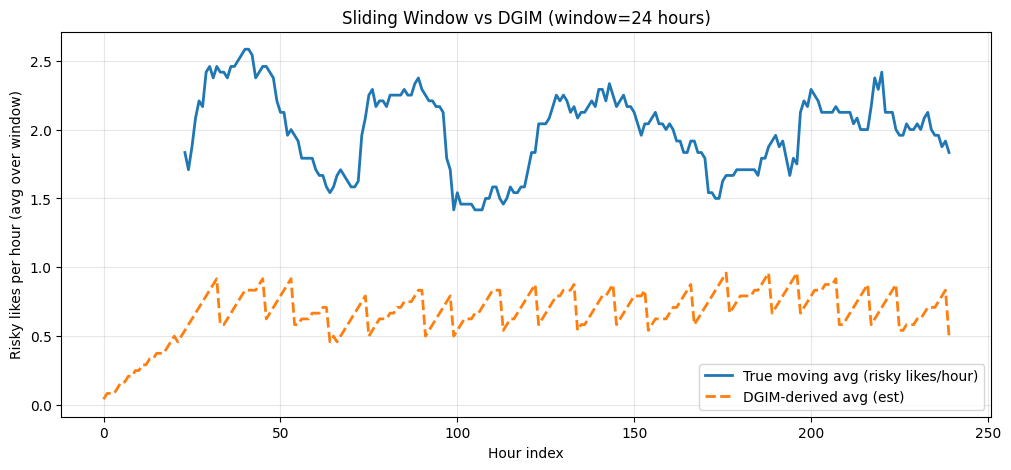

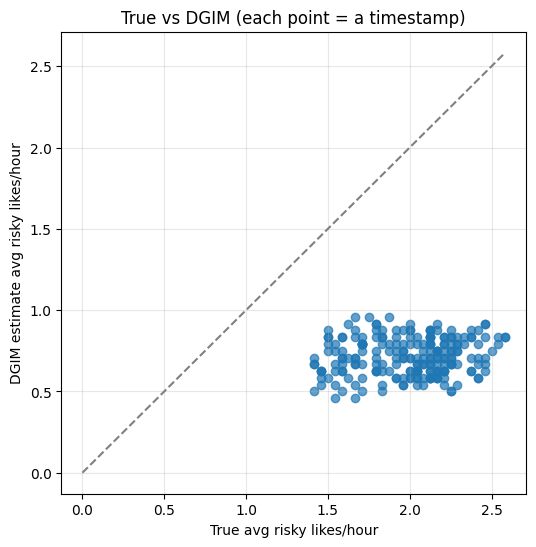


Final DGIM buckets (non-empty levels):
Level 0 (bucket size 1): [Bucket(ts=238, size=1), Bucket(ts=239, size=1)]
Level 1 (bucket size 2): [Bucket(ts=237, size=2)]
Level 2 (bucket size 4): [Bucket(ts=233, size=4)]
Level 3 (bucket size 8): [Bucket(ts=224, size=8)]


In [115]:
"""
Compare Sliding Window (Simple Moving Average) vs DGIM for detecting
recent likes on suicide-related posts.
"""

import math
import random
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# DGIM classes (unchanged core idea, compact)
# -----------------------
class DGIM_Bucket:
    def __init__(self, timestamp, size=1):
        self.timestamp = timestamp
        self.size = size
    def __repr__(self):
        return f"Bucket(ts={self.timestamp}, size={self.size})"

class DGIM:
    def __init__(self, N):
        if N <= 0:
            raise ValueError("N must be > 0")
        self.N = N
        self.timestamp = 0
        # levels up to log2(N) + 2
        num_levels = int(math.log2(N)) + 3
        self.buckets = [deque() for _ in range(num_levels)]

    def update(self, bit):
        """Process a bit (0/1)"""
        self.timestamp += 1
        # prune old buckets (older than window)
        cutoff = self.timestamp - self.N
        for level_q in self.buckets:
            while level_q and level_q[0].timestamp <= cutoff:
                level_q.popleft()
        if bit == 0:
            return
        new_bucket = DGIM_Bucket(self.timestamp, 1)
        self._merge(new_bucket, 0)

    def _merge(self, bucket, level):
        # ensure buckets list large enough
        if level >= len(self.buckets):
            self.buckets.append(deque())
        self.buckets[level].append(bucket)
        # if > 2 buckets, merge two oldest
        if len(self.buckets[level]) > 2:
            b1 = self.buckets[level].popleft()  # oldest
            b2 = self.buckets[level].popleft()  # next-oldest
            merged = DGIM_Bucket(timestamp=b2.timestamp, size=b1.size * 2)
            self._merge(merged, level + 1)

    def query(self):
        """Estimate number of 1s in last N bits"""
        total = 0
        cutoff = self.timestamp - self.N
        last_bucket = None
        # iterate from smallest level to largest
        for level_q in self.buckets:
            for b in level_q:
                if b.timestamp > cutoff:
                    total += b.size
                    # track the oldest bucket included
                    if last_bucket is None or b.timestamp < last_bucket.timestamp:
                        last_bucket = b
        if last_bucket is None:
            return 0
        # subtract half of last_bucket.size to reduce overcount
        total -= (last_bucket.size // 2)
        return total

# -----------------------
# Simulation of social stream
# -----------------------
def simulate_stream_hours(num_hours=200, seed=42):
    """
    Returns:
      - like_counts: list of ints = total likes per hour
      - risky_likes: list of ints = number of likes for suicide-related posts per hour
      - risky_binary_stream: flattened binary stream at 'like event' resolution is not necessary;
        DGIM expects a bit per time-step, so we treat each hour as a single time-step where the bit is 1
        if a risky like occurred in that hour. But here we want counts in the window, so we will feed DGIM
        with a stream where we expand each hour into 'risky_likes' bits of 1 and then zeros for other ticks.
        For simplicity and clarity we keep DGIM at *hour resolution* where bit=1 indicates "there was >=1 risky like".
    """
    random.seed(seed)
    like_counts = []
    risky_likes = []
    # simulate cyclical behaviour + noise; some hours have many likes; risky fraction varies
    for t in range(num_hours):
        base = 15 + 8 * math.sin(2 * math.pi * (t % 24) / 24.0)  # daily pattern
        noise = random.gauss(0, 3)
        total_likes = max(0, int(round(base + noise)))
        # risky fraction higher at night (simulate)
        hour = t % 24
        if 0 <= hour <= 5:  # late night
            risky_frac = 0.25 + random.uniform(-0.05, 0.05)
        elif 18 <= hour <= 23:
            risky_frac = 0.18 + random.uniform(-0.05, 0.05)
        else:
            risky_frac = 0.05 + random.uniform(-0.03, 0.03)
        risky = sum(1 for _ in range(total_likes) if random.random() < risky_frac)
        like_counts.append(int(total_likes))
        risky_likes.append(int(risky))
    return like_counts, risky_likes

# -----------------------
# Moving Average (on risky_likes per hour)
# -----------------------
def sliding_window_moving_average(risky_likes, window_size):
    """
    Compute exact moving average (risky likes per hour) over sliding window.
    Returns list of same length: at each step i, the average over last window_size hours,
    or None if window not full (we will return average only when window is full).
    """
    out = []
    window = deque(maxlen=window_size)
    for x in risky_likes:
        window.append(x)
        if len(window) == window_size:
            out.append(sum(window) / window_size)
        else:
            out.append(None)
    return out

# -----------------------
# DGIM adaptation
# -----------------------
# DGIM is designed to approximate count of 1s in last N bits. For our problem:
#  - we want counts of risky likes in last N hours. We treat each hour as one bit (1 if there was >=1 risky like in that hour).

def run_comparison(like_counts, risky_likes, window_hours=24):
    """
    Compare moving average (exact) vs DGIM estimate.
      -  hour-level DGIM bits: bit = 1 if risky_likes_in_hour >= 1
    """
    n = len(risky_likes)
    # Exact moving average of counts per hour
    moving_avg = sliding_window_moving_average(risky_likes, window_hours)

    # Prepare stream for DGIM

    # hour-level bits
    dgim_stream = [1 if r >= 1 else 0 for r in risky_likes]
    dgim = DGIM(N=window_hours)
    dgim_estimates = []
    # For comparison we want DGIM estimation of count of 1s in last window hours
    for bit in dgim_stream:
        dgim.update(bit)
        est = dgim.query()
        # est is count of hours with >=1 risky like; convert to avg risky likes per hour approx by dividing by window_hours
        dgim_estimates.append(est / window_hours)

    # Calculate true rate (exact) as moving_avg, and replace None with np.nan for plotting
    true_rate = np.array([v if v is not None else np.nan for v in moving_avg])
    dgim_rate = np.array(dgim_estimates)

    # Compute error metrics where true_rate is available (window full)
    mask = ~np.isnan(true_rate)
    if mask.sum() == 0:
        raise ValueError("Window never filled; increase stream length or reduce window.")
    mae = np.mean(np.abs(dgim_rate[mask] - true_rate[mask]))
    rmse = math.sqrt(np.mean((dgim_rate[mask] - true_rate[mask])**2))
    # relative error: mean(|estimate - true| / true) but avoid division by zero
    rel_errors = []
    for t, e in zip(true_rate[mask], dgim_rate[mask]):
        if t == 0:
            # if true 0, measure absolute error instead
            rel_errors.append(abs(e - t))
        else:
            rel_errors.append(abs(e - t) / t)
    mean_rel_error = float(np.mean(rel_errors))

    return {
        "true_rate": true_rate,
        "dgim_rate": dgim_rate,
        "mae": mae,
        "rmse": rmse,
        "mean_rel_error": mean_rel_error
    }

# -----------------------
# Run simulation + comparison + plotting
# -----------------------
def main_demo():
    like_counts, risky_likes = simulate_stream_hours(num_hours=240, seed=2025)
    print(f"Simulated {len(like_counts)} hours. Example likes (first 24):")
    print(like_counts[:24])
    print("Example risky likes (first 24):")
    print(risky_likes[:24])

    window = 24  # last 24 hours window
    print(f"\nComparing window size = {window} hours\n")

    results = run_comparison(like_counts, risky_likes, window_hours=window)

    true_rate = results["true_rate"]
    dgim_rate = results["dgim_rate"]

    # Print a few timesteps
    print("\nTimestamp | True (avg risky/hour) | DGIM estimate (avg risky/hour)")
    for i in range(len(true_rate)):
        if math.isnan(true_rate[i]):  # window not full
            print(f"{i:3d}       |   (filling window...)")
        else:
            print(f"{i:3d}       |   {true_rate[i]:6.3f}               |   {dgim_rate[i]:6.3f}")

    print("\nError metrics (over timesteps where window full):")
    print(f"MAE:  {results['mae']:.4f} (avg risky likes/hour)")
    print(f"RMSE: {results['rmse']:.4f}")
    print(f"Mean relative error: {results['mean_rel_error']:.3f}")

    # Plotting
    hrs = np.arange(len(true_rate))
    plt.figure(figsize=(12, 5))
    plt.plot(hrs, true_rate, label="True moving avg (risky likes/hour)", linewidth=2)
    plt.plot(hrs, dgim_rate, label="DGIM-derived avg (est)", linewidth=2, linestyle="--")
    plt.xlabel("Hour index")
    plt.ylabel("Risky likes per hour (avg over window)")
    plt.title(f"Sliding Window vs DGIM (window={window} hours)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Scatter of true vs estimate
    mask = ~np.isnan(true_rate)
    plt.figure(figsize=(6,6))
    plt.scatter(true_rate[mask], dgim_rate[mask], alpha=0.7)
    maxv = max(true_rate[mask].max(), dgim_rate[mask].max())
    plt.plot([0, maxv], [0, maxv], linestyle='--', color='gray')
    plt.xlabel("True avg risky likes/hour")
    plt.ylabel("DGIM estimate avg risky likes/hour")
    plt.title("True vs DGIM (each point = a timestamp)")
    plt.grid(alpha=0.3)
    plt.show()

    # Show final DGIM buckets for introspection
    # Re-run DGIM to extract buckets state
    dg = DGIM(N=window)
    for bit in [1 if r >= 1 else 0 for r in risky_likes]:
        dg.update(bit)
    print("\nFinal DGIM buckets (non-empty levels):")
    for i, q in enumerate(dg.buckets):
        if q:
            print(f"Level {i} (bucket size {2**i}): {list(q)}")

if __name__ == "__main__":
    main_demo()


The reason DGIM had such high error was because we were not using a fine -grained approach. Below we expand each hour into multiple unit-ticks (one per risky like) and run DGIM on that fine-grained stream. This is more computationally expensive but accurate.

Simulated 240 hours of activity.
First 10 hours, total likes: [11, 16, 20, 17, 20, 25, 22, 26, 25, 16]
First 10 hours, risky likes: [6, 3, 0, 2, 7, 3, 0, 3, 2, 1]

Event-level stream length (total likes): 3599
Overall fraction of likes that are risky: 0.130

Comparing over a sliding window of the last 500 like events...

Index | Bit | True count in last N | DGIM estimate
   0 |  1  |    1               |    1
   1 |  0  |    1               |    1
   2 |  0  |    1               |    1
   3 |  0  |    1               |    1
   4 |  1  |    2               |    2
   5 |  1  |    3               |    2
   6 |  1  |    4               |    3
   7 |  0  |    4               |    3
   8 |  0  |    4               |    3
   9 |  1  |    5               |    4
  10 |  1  |    6               |    5
  11 |  0  |    6               |    5
  12 |  0  |    6               |    5
  13 |  0  |    6               |    5
  14 |  0  |    6               |    5
  15 |  0  |    6               |    5
  

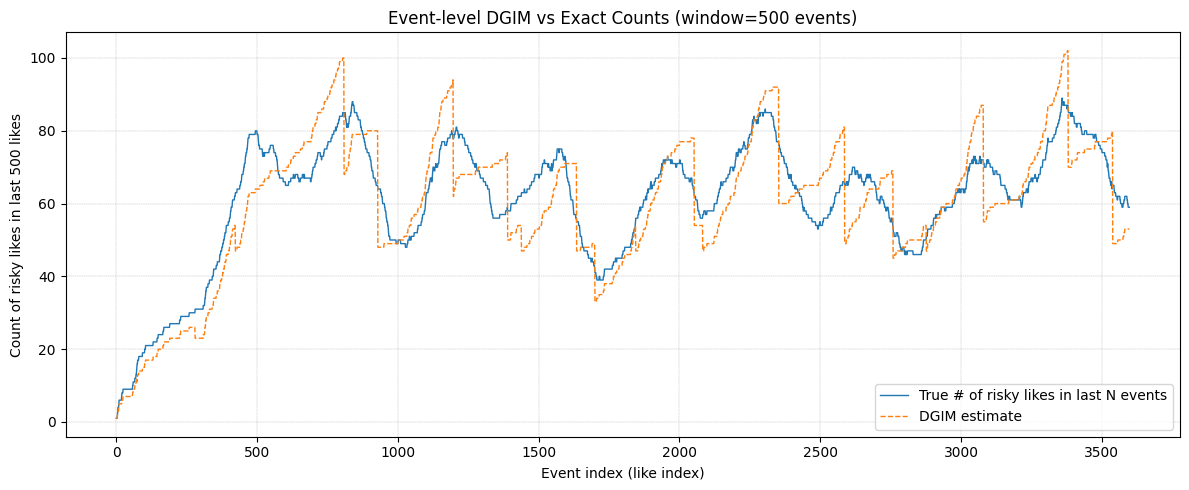

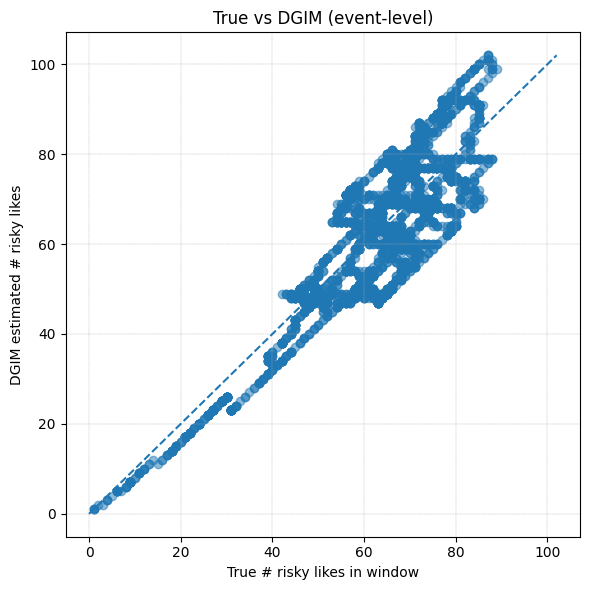


Final DGIM buckets (non-empty levels):
Level 0 (bucket size 1): [Bucket(ts=3583, size=1)]
Level 1 (bucket size 2): [Bucket(ts=3558, size=2), Bucket(ts=3580, size=2)]
Level 2 (bucket size 4): [Bucket(ts=3476, size=4), Bucket(ts=3539, size=4)]
Level 3 (bucket size 8): [Bucket(ts=3396, size=8)]
Level 4 (bucket size 16): [Bucket(ts=3357, size=16)]
Level 5 (bucket size 32): [Bucket(ts=3293, size=32)]


In [118]:
"""
Event-level DGIM vs exact counts for suicide-related likes.

Each event = one 'like' on social media:
  - bit = 1 if like was on a suicide-related post
  - bit = 0 otherwise

We compare:
  - True # of 1s in the last N_events likes (exact sliding window)
  - DGIM estimate of that count
"""

import math
import random
from collections import deque

import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# DGIM classes
# -----------------------
class DGIM_Bucket:
    def __init__(self, timestamp, size=1):
        self.timestamp = timestamp  # index of the most recent 1 in this bucket
        self.size = size            # number of 1s in this bucket (power of 2)

    def __repr__(self):
        return f"Bucket(ts={self.timestamp}, size={self.size})"


class DGIM:
    """
    DGIM algorithm: approximate count of 1s over the last N bits (sliding window)
    using O(log^2 N) memory.
    """
    def __init__(self, N):
        if N <= 0:
            raise ValueError("N must be > 0")
        self.N = N
        self.timestamp = 0
        num_levels = int(math.log2(N)) + 3   # enough levels for sizes up to ~N
        self.buckets = [deque() for _ in range(num_levels)]

    def update(self, bit):
        """Process the next bit in the stream (0 or 1)."""
        self.timestamp += 1

        # 1) Remove buckets that are completely out of the window
        cutoff = self.timestamp - self.N
        for level_q in self.buckets:
            while level_q and level_q[0].timestamp <= cutoff:
                level_q.popleft()

        if bit == 0:
            return

        # 2) New bucket of size 1 at level 0 (for this 1)
        new_b = DGIM_Bucket(self.timestamp, size=1)
        self._merge(new_b, level=0)

    def _merge(self, bucket, level):
        """Add bucket at 'level'; if >2 buckets, merge the two oldest."""
        if level >= len(self.buckets):
            self.buckets.append(deque())

        self.buckets[level].append(bucket)

        if len(self.buckets[level]) > 2:
            # merge the two oldest buckets
            b1 = self.buckets[level].popleft()
            b2 = self.buckets[level].popleft()
            merged = DGIM_Bucket(timestamp=b2.timestamp, size=b1.size * 2)
            self._merge(merged, level + 1)

    def query(self):
        """Estimate number of 1s in last N bits."""
        total = 0
        cutoff = self.timestamp - self.N
        last_bucket = None

        for level_q in self.buckets:
            for b in level_q:
                if b.timestamp > cutoff:
                    total += b.size
                    if last_bucket is None or b.timestamp < last_bucket.timestamp:
                        last_bucket = b

        if last_bucket is None:
            return 0

        # subtract half of the last bucket to reduce overcount
        total -= (last_bucket.size // 2)
        return total


# -----------------------
# Simulate social stream (hour-level likes -> event-level bits)
# -----------------------
def simulate_stream_hours(num_hours=200, seed=42):
    """
    Simulate:
      - total likes per hour
      - risky likes (suicide-related) per hour
    """
    random.seed(seed)
    like_counts = []
    risky_likes = []

    for t in range(num_hours):
        # a daily pattern + noise for total likes
        base = 15 + 8 * math.sin(2 * math.pi * (t % 24) / 24.0)
        noise = random.gauss(0, 3)
        total_likes = max(0, int(round(base + noise)))

        # at night & evening, higher fraction of risky / crisis content
        hour = t % 24
        if 0 <= hour <= 5:       # late night
            risky_frac = 0.25 + random.uniform(-0.05, 0.05)
        elif 18 <= hour <= 23:   # evening
            risky_frac = 0.18 + random.uniform(-0.05, 0.05)
        else:                    # daytime
            risky_frac = 0.05 + random.uniform(-0.03, 0.03)

        risky = sum(1 for _ in range(total_likes) if random.random() < risky_frac)
        like_counts.append(total_likes)
        risky_likes.append(risky)

    return like_counts, risky_likes


def build_event_level_stream(like_counts, risky_likes, shuffle_within_hour=True):
    """
    Build event-level binary stream:
      - one element per like event
      - 1 = like on a suicide-related post
      - 0 = like on a normal post

    We simulate all likes within an hour, then extend the global stream.
    """
    binary_stream = []

    for total, risky in zip(like_counts, risky_likes):
        safe = max(0, total - risky)
        bits = [1] * risky + [0] * safe
        if shuffle_within_hour:
            random.shuffle(bits)
        binary_stream.extend(bits)

    return binary_stream


# -----------------------
# Event-level DGIM vs exact sliding window
# -----------------------
def compare_event_level_dgim(binary_stream, window_events=500):
    """
    Compare DGIM's estimate of number of 1s in last `window_events` bits
    vs the exact count.
    """
    dgim = DGIM(N=window_events)

    true_counts = []   # exact sliding-window count
    est_counts = []    # DGIM estimate

    for i, bit in enumerate(binary_stream):
        dgim.update(bit)

        # true count over last window_events bits
        start = max(0, i + 1 - window_events)
        window = binary_stream[start : i + 1]
        true = sum(window)

        est = dgim.query()

        true_counts.append(true)
        est_counts.append(est)

    true_arr = np.array(true_counts, dtype=float)
    est_arr = np.array(est_counts, dtype=float)

    # compute errors only where window is "full enough" (we can still compute from the beginning though)
    # Here we just compute over all timesteps (including warmup)
    mae = float(np.mean(np.abs(true_arr - est_arr)))
    rmse = float(np.sqrt(np.mean((true_arr - est_arr) ** 2)))

    # Relative error: avoid division by zero
    rel_errors = []
    for t, e in zip(true_arr, est_arr):
        if t == 0:
            # if true == 0, measure absolute error directly
            rel_errors.append(abs(e - t))
        else:
            rel_errors.append(abs(e - t) / t)
    mean_rel_error = float(np.mean(rel_errors))

    return {
        "true_counts": true_arr,
        "est_counts": est_arr,
        "mae": mae,
        "rmse": rmse,
        "mean_rel_error": mean_rel_error,
    }


# -----------------------
# Demo Runner
# -----------------------
def main():
    # 1) Simulate a few hundred hours of activity
    like_counts, risky_likes = simulate_stream_hours(num_hours=240, seed=2025)

    print(f"Simulated {len(like_counts)} hours of activity.")
    print("First 10 hours, total likes:", like_counts[:10])
    print("First 10 hours, risky likes:", risky_likes[:10])

    # 2) Build event-level binary stream (one bit per like)
    binary_stream = build_event_level_stream(like_counts, risky_likes)
    print(f"\nEvent-level stream length (total likes): {len(binary_stream)}")
    risky_frac = sum(binary_stream) / len(binary_stream) if binary_stream else 0.0
    print(f"Overall fraction of likes that are risky: {risky_frac:.3f}")

    # 3) Compare DGIM vs exact counts over last N events (sliding window)
    window_events = 500  # last 500 likes
    print(f"\nComparing over a sliding window of the last {window_events} like events...\n")
    results = compare_event_level_dgim(binary_stream, window_events=window_events)

    true_counts = results["true_counts"]
    est_counts = results["est_counts"]

    # 4) Print some samples
    print("Index | Bit | True count in last N | DGIM estimate")
    for i in range(0, min(80, len(binary_stream))):
        print(f"{i:4d} |  {binary_stream[i]}  | {int(true_counts[i]):4d}               | {int(est_counts[i]):4d}")

    print("\n--- Error metrics over entire event stream ---")
    print(f"MAE:            {results['mae']:.3f} (events)")
    print(f"RMSE:           {results['rmse']:.3f}")
    print(f"Mean rel error: {results['mean_rel_error']:.3f}")

    # 5) Plot (True vs DGIM)
    xs = np.arange(len(true_counts))

    plt.figure(figsize=(12, 5))
    plt.plot(xs, true_counts, label="True # of risky likes in last N events", linewidth=1)
    plt.plot(xs, est_counts, label="DGIM estimate", linewidth=1, linestyle="--")
    plt.xlabel("Event index (like index)")
    plt.ylabel(f"Count of risky likes in last {window_events} likes")
    plt.title(f"Event-level DGIM vs Exact Counts (window={window_events} events)")
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.3)
    plt.tight_layout()
    plt.show()

    # Scatter: True vs Estimated
    plt.figure(figsize=(6, 6))
    plt.scatter(true_counts, est_counts, alpha=0.5)
    maxv = max(true_counts.max(), est_counts.max())
    plt.plot([0, maxv], [0, maxv], linestyle="--")
    plt.xlabel("True # risky likes in window")
    plt.ylabel("DGIM estimated # risky likes")
    plt.title("True vs DGIM (event-level)")
    plt.grid(True, linestyle="--", linewidth=0.3)
    plt.tight_layout()
    plt.show()

    # 6) Show final bucket structure (for intuition)
    dgim = DGIM(N=window_events)
    for bit in binary_stream:
        dgim.update(bit)
    print("\nFinal DGIM buckets (non-empty levels):")
    for i, q in enumerate(dgim.buckets):
        if q:
            print(f"Level {i} (bucket size {2**i}): {list(q)}")


if __name__ == "__main__":
    main()
